# 🌿 Plant Disease Classification using Deep Learning (End-to-End Project)

This project presents a complete **end-to-end pipeline** for detecting and classifying **plant leaf diseases** using **Convolutional Neural Networks (CNN)** and **Transfer Learning (MobileNetV2)**.  
The goal is to assist in **early detection of crop diseases**, helping farmers and agricultural researchers make informed decisions to prevent yield loss.

###  Key Highlights
- **Dataset:** PlantVillage dataset containing healthy and diseased leaf images of multiple plant species.  
- **Approach:** Combination of a **custom-built CNN** and a **pre-trained MobileNetV2** model for accurate classification.  
- **Environment:** Entirely implemented in **Google Colab** for reproducibility and seamless integration with Google Drive.  
- **Techniques Used:** Data preprocessing, augmentation, visualization, model training, Grad-CAM interpretability, and data drift detection.  
- **Outcome:** Robust models capable of predicting plant diseases from unseen images with high accuracy and visual explainability.

This notebook demonstrates not just model training but also **evaluation, interpretability, and maintenance techniques**, representing a complete deep learning workflow from **data to deployment-ready model**.


####**SECTION 1 — SETUP**

### Installing Dependencies

In this step, we install the necessary Python libraries required for building and training the CNN model.  
TensorFlow is used for creating and training the neural network, while other libraries such as scikit-learn, Seaborn, Matplotlib, and OpenCV are used for data handling, visualization, and image processing.


In [1]:
!pip install -q tensorflow
!pip install -q scikit-learn seaborn matplotlib opencv-python

### Installing NumPy

NumPy is a core Python library for numerical computing.  
It provides powerful tools for handling arrays, matrices, and performing mathematical operations efficiently.  
We install it separately here to ensure compatibility with TensorFlow and other libraries.


In [2]:
!pip install -q numpy

### Mounting Google Drive

In this step, we mount Google Drive to access datasets and save model files directly to the cloud.  
This allows the notebook to load training images and store the trained model (`.keras` file) for later use.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Required Libraries

In this section, we import all the essential Python libraries used throughout the project:

- **os, shutil, zipfile, random** – for file handling and directory management  
- **NumPy, Pandas** – for numerical computations and data manipulation  
- **Matplotlib, Seaborn** – for data visualization  
- **TensorFlow / Keras** – for building and training the Convolutional Neural Network (CNN)  
- **PIL (Python Imaging Library)** – for basic image operations  

These libraries together form the foundation for preprocessing, training, and evaluating our deep learning model.


In [4]:
import os, shutil, zipfile, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image

### Setting Up Model Paths

Here, we define the file paths for saving and loading trained models directly from Google Drive.  
This ensures that the models persist between sessions and can be reused without retraining.

- The **base path** points to the project folder inside Google Drive.  
- A **models/** directory is created automatically if it doesn’t exist.  
- The script defines filenames for both the **custom CNN model** and the **MobileNetV2 model**.  
- Full paths are constructed using `os.path.join` for reliability across systems.


In [5]:
# Base directory for your Deep Learning project in Google Drive
drive_project_path = "/content/drive/MyDrive/DeepLearningProject"

# Create a subdirectory for storing trained models (if it doesn't already exist)
model_save_dir = os.path.join(drive_project_path, "models")
os.makedirs(model_save_dir, exist_ok=True)

# Filenames for saved models
cnn_model_filename = "best_custom_cnn_model.keras"
mobilenet_model_filename = "best_mobilenet_model.keras"

# Construct full model file paths
cnn_model_path = os.path.join(model_save_dir, cnn_model_filename)
mobilenet_model_path = os.path.join(model_save_dir, mobilenet_model_filename)

# Confirm paths for verification
print(f"Custom CNN model path: {cnn_model_path}")
print(f"MobileNetV2 model path: {mobilenet_model_path}")

Custom CNN model path: /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
MobileNetV2 model path: /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras


### Checking GPU Availability

Before starting model training, we verify that a GPU is available in the Colab environment.  
Using a GPU significantly speeds up deep learning tasks such as model training and image processing.  
If no GPU is detected, you can enable one by going to **Runtime → Change runtime type → Hardware accelerator → GPU**.


In [6]:
# Verify GPU access
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Extracting the Dataset

In this step, we extract the compressed dataset stored in Google Drive.  
The dataset archive (`archive.zip`) is located in the project directory and is extracted to a local folder in the Colab environment.

After extraction:
- The images are ready for preprocessing and training.  
- We verify the extraction by listing the contents of the dataset folder.


In [7]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/DeepLearningProject/archive.zip"
extract_path = "/content/plantvillage"

# Check if dataset already extracted
if not os.path.exists(extract_path) or len(os.listdir(extract_path)) == 0:
    print("📦 Extracting dataset... Please wait...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted successfully!")
else:
    print("📂 Dataset already extracted — skipping extraction.")

# Verify extraction by listing first few items
print("\n📁 Extracted folders/files:")
print(os.listdir(extract_path)[:10])


📦 Extracting dataset... Please wait...
✅ Dataset extracted successfully!

📁 Extracted folders/files:
['plantvillage dataset']


### Removing Corrupt or Unreadable Images

Before training, it’s important to ensure that all images in the dataset are valid and readable.  
This function scans through the dataset directory and attempts to open each image using the **Pillow (PIL)** library.  

If an image file is found to be corrupt or unreadable, it is automatically removed to prevent errors during training.  
This step improves data quality and ensures smooth model execution.


In [8]:
def remove_corrupt_images(root_dir):

    removed = 0
    for root, _, files in os.walk(root_dir):
        for f in files:
            path = os.path.join(root, f)
            try:
                # Try to open the image
                img = Image.open(path)
                img.verify()  # verifies the file without loading into memory
            except Exception:
                try:
                    os.remove(path)
                    removed += 1
                except:
                    pass
    print(f"✅ Scan complete — removed {removed} corrupt or unreadable files.")


### Merging Dataset Variants

The PlantVillage dataset contains multiple variants of images — such as **color**, **grayscale**, and **segmented** versions.  
In this step, we merge all these variants into a single directory to create one comprehensive dataset for model training.

- The function `merge_datasets()` copies images from all variant folders into a combined dataset folder.  
- It ensures no duplicates are overwritten.  
- This unified dataset simplifies preprocessing and improves model generalization.


In [9]:
# Base path to the extracted dataset
base_path = "/content/plantvillage/plantvillage dataset"

# Subdirectories for different dataset variants
color_path = os.path.join(base_path, "color")
gray_path = os.path.join(base_path, "grayscale")
seg_path = os.path.join(base_path, "segmented")

# Destination folder for the merged dataset
merged_path = os.path.join(base_path, "combined_dataset")
os.makedirs(merged_path, exist_ok=True)

def merge_datasets(source_dirs, dest_dir):
    for source in source_dirs:
        if not os.path.exists(source):
            print(f"⚠️ Skipped (not found): {source}")
            continue
        for class_name in os.listdir(source):
            class_dir = os.path.join(source, class_name)
            if os.path.isdir(class_dir):
                dest_class_dir = os.path.join(dest_dir, class_name)
                os.makedirs(dest_class_dir, exist_ok=True)
                for img_file in os.listdir(class_dir):
                    src_file = os.path.join(class_dir, img_file)
                    dest_file = os.path.join(dest_class_dir, img_file)
                    if not os.path.exists(dest_file):
                        shutil.copy(src_file, dest_file)
    print("✅ All dataset variants merged successfully!")

# Execute merge
merge_datasets([color_path, gray_path, seg_path], merged_path)


✅ All dataset variants merged successfully!


### Cleaning the Merged Dataset

After merging all dataset variants into a single folder, we run the `remove_corrupt_images()` function again.  
This ensures that any unreadable or damaged image files that might have appeared during the merge process are removed.

Running this step guarantees that the final dataset used for training contains only valid, high-quality images.


In [10]:
remove_corrupt_images(merged_path)

✅ Scan complete — removed 0 corrupt or unreadable files.


####**SECTION 2 — DATA PREPARATION**

### Creating Training and Validation Sets

In this step, we prepare the dataset for model training using Keras’ `ImageDataGenerator`.

- **Training Data Generator:**  
  Applies data augmentation techniques such as rotation, zoom, shifting, shearing, and flipping.  
  These transformations help improve model generalization and prevent overfitting.

- **Validation Data Generator:**  
  Only rescales the images without any augmentation to evaluate the model’s true performance.

The dataset is split into **80% training** and **20% validation** subsets using the `validation_split` parameter.


In [11]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Maintain same split ratio for both sets
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only, no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training dataset (80% of data)
train_set = train_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Validation dataset (20% of data)
val_set = val_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 86904 images belonging to 38 classes.
Found 21707 images belonging to 38 classes.


### **Saving Training Data Distribution:**

In this step, we compute how many images belong to each class in the original training dataset. This gives us the baseline class distribution, which is later used to detect data drift when new images are uploaded in the Streamlit app.
The distribution is saved as train_distribution.json so the dashboard can compare future data against this baseline.

In [12]:
import json
from collections import Counter

# Count class frequencies in training set
train_labels = train_set.classes
train_class_counts = Counter(train_labels)

# Map numeric labels → class names
index_to_class = {v: k for k, v in train_set.class_indices.items()}

train_distribution = {
    index_to_class[i]: int(count) for i, count in train_class_counts.items()
}

# Save to Google Drive
save_path = "/content/drive/MyDrive/DeepLearningProject/history/train_distribution.json"
with open(save_path, "w") as f:
    json.dump(train_distribution, f, indent=4)

print("Training distribution saved:", save_path)


Training distribution saved: /content/drive/MyDrive/DeepLearningProject/history/train_distribution.json


### Visualizing Sample Training Images

Before training the CNN model, it is helpful to inspect a few sample images from the training set to ensure that preprocessing and augmentation are working correctly.

In this step:
- A batch of images is retrieved from the training generator.  
- Nine images are displayed in a 3×3 grid.  
- Each image is shown with its corresponding class label.  

This quick visualization helps verify that the dataset has been loaded properly and that image augmentation is applied as expected.


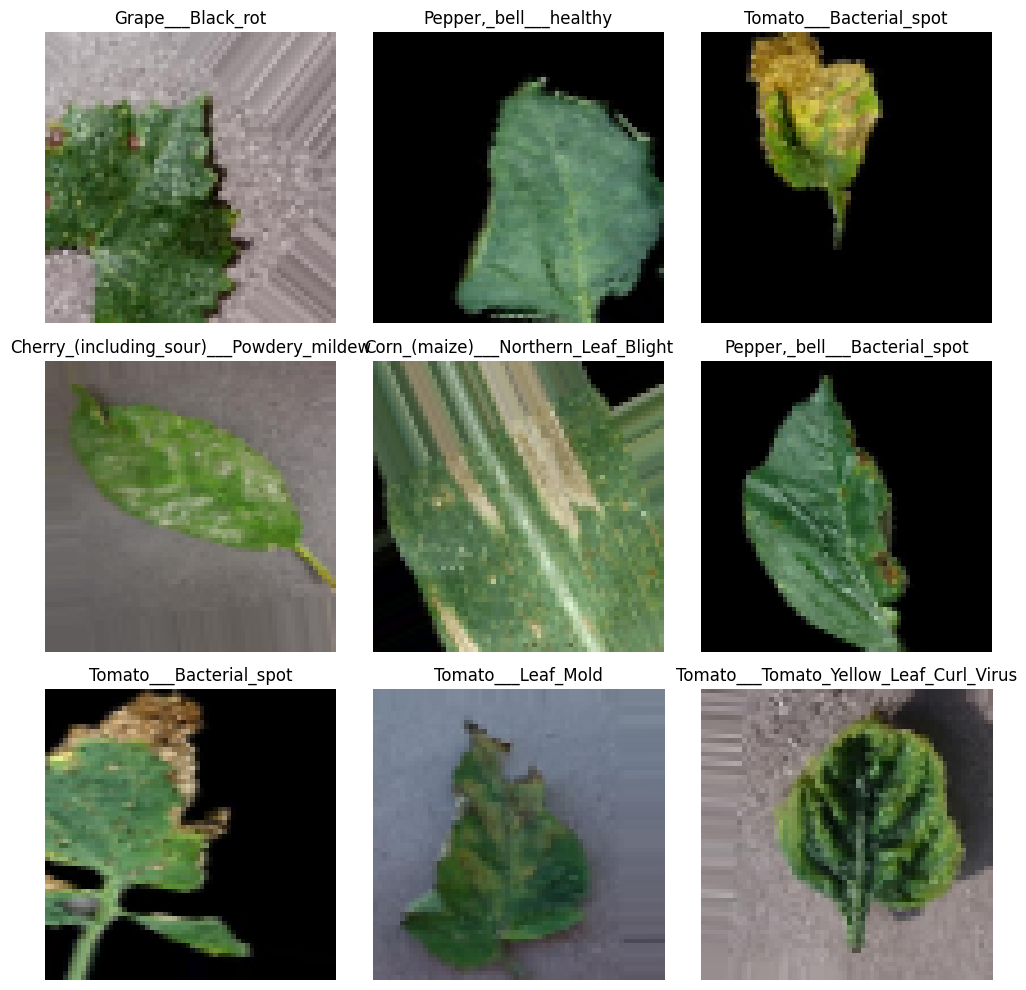

In [ ]:
#Visualize a sample of training images
images, labels = next(train_set)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(list(train_set.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

### Checking Class Distribution

To ensure that the dataset is balanced, we examine the number of images in each class for both the training and validation sets.

In this step:
- The **`Counter`** class is used to count how many images belong to each class.  
- Separate counts are displayed for the training (80%) and validation (20%) subsets.  
- A balanced dataset helps the CNN model learn effectively and prevents bias toward any single class.


In [ ]:
from collections import Counter

# Get class names from the generator
class_names = list(train_set.class_indices.keys())

# Training set distribution
train_counts = Counter(train_set.classes)
print("✅ Class distribution in the TRAINING set (80%):")
for i in range(len(class_names)):
    print(f"{class_names[i]}: {train_counts[i]} images")

print("\n" + "="*30 + "\n")

# Validation set distribution
val_counts = Counter(val_set.classes)
print("✅ Class distribution in the VALIDATION set (20%):")
for i in range(len(class_names)):
    print(f"{class_names[i]}: {val_counts[i]} images")

✅ Class distribution in the TRAINING set (80%):
Apple___Apple_scab: 1008 images
Apple___Black_rot: 994 images
Apple___Cedar_apple_rust: 440 images
Apple___healthy: 2632 images
Blueberry___healthy: 2404 images
Cherry_(including_sour)___Powdery_mildew: 1684 images
Cherry_(including_sour)___healthy: 1367 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 821 images
Corn_(maize)___Common_rust_: 1908 images
Corn_(maize)___Northern_Leaf_Blight: 1576 images
Corn_(maize)___healthy: 1860 images
Grape___Black_rot: 1888 images
Grape___Esca_(Black_Measles): 2214 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 images
Grape___healthy: 677 images
Orange___Haunglongbing_(Citrus_greening): 8812 images
Peach___Bacterial_spot: 3676 images
Peach___healthy: 576 images
Pepper,_bell___Bacterial_spot: 1596 images
Pepper,_bell___healthy: 2365 images
Potato___Early_blight: 1600 images
Potato___Late_blight: 1600 images
Potato___healthy: 244 images
Raspberry___healthy: 594 images
Soybean___healthy

### Visualizing Class Distribution

After checking the numerical class counts, we visualize the dataset distribution using a bar chart.  
This plot shows how many images belong to each class, helping us confirm whether the dataset is balanced or if certain classes have significantly more samples.

A balanced dataset ensures fair model training and improves classification accuracy.


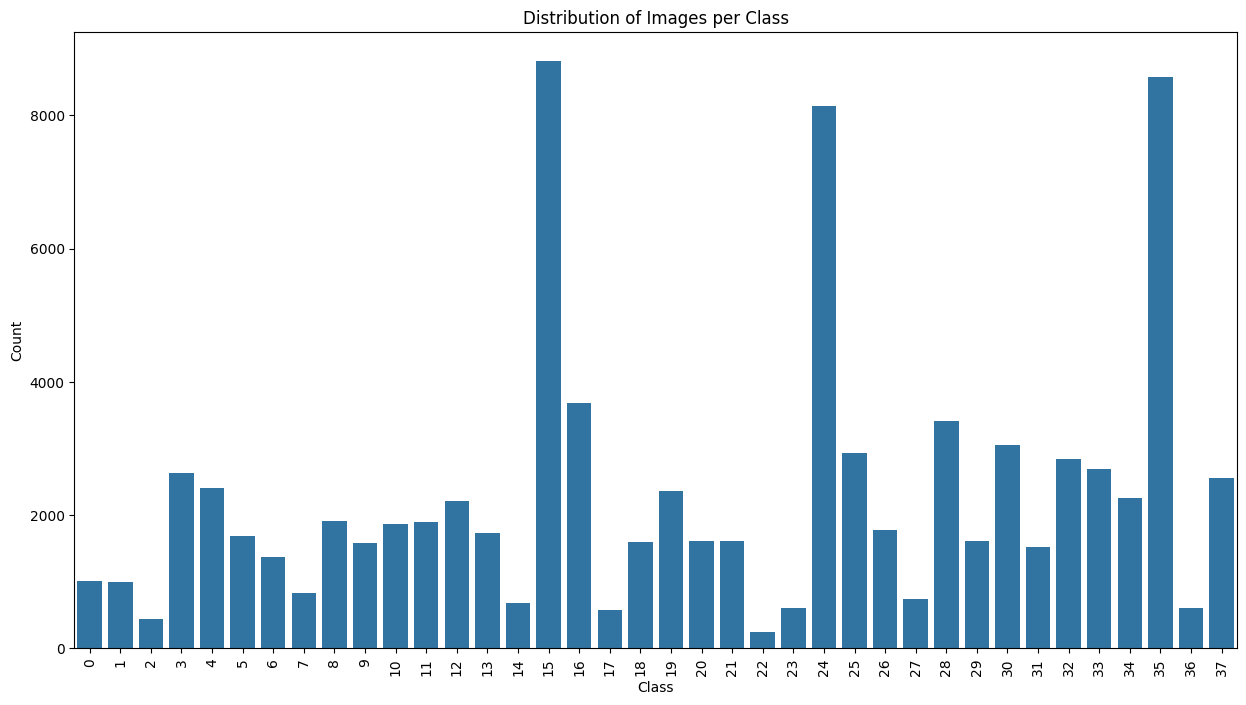

In [ ]:
# Visualize class distribution
df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
plt.figure(figsize=(15, 8))
sns.barplot(x='Class', y='Count', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Images per Class')
plt.show()

**SECTION 3 — CUSTOM CNN MODEL**

### Building the CNN Model

In this section, we define a **Convolutional Neural Network (CNN)** architecture for classifying plant images.  
The network is designed to automatically learn spatial patterns such as edges, textures, and shapes from the leaf images.

The model consists of:
- **Three convolutional blocks** with Conv2D, Batch Normalization, and MaxPooling layers for feature extraction.  
- A **Flatten layer** to convert the 2D features into a 1D vector.  
- A **Dense layer** with ReLU activation and Dropout for regularization.  
- A **final softmax output layer** for multi-class classification based on the number of plant categories.

Finally, the model summary is displayed to show the layer structure and parameter counts.


In [ ]:
# Define CNN Model Architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

model = Sequential([
    Input(shape=(64, 64, 3)),

    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(train_set.num_classes, activation='softmax')
])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,998 (2.63 MB)

 Trainable params: 688,550 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

### **Custom CNN – Training Setup & Model Fitting**

In this step, we prepare and train the Custom CNN model:

- Compilation: The network is compiled using the adam optimizer and categorical_crossentropy loss, with accuracy as the evaluation metric.

- Callbacks:

   - EarlyStopping prevents overfitting by stopping training when validation loss stops improving.

  - ModelCheckpoint automatically saves the best model based on validation accuracy.

- Training: The model is then trained on the augmented training set and validated on the validation set for up to 20 epochs.

- Output: Training returns a history_cnn object that will be used later to plot accuracy and loss curves.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf
import math
import os

# Learning rate scheduler (same pattern used in MobileNet)
def cnn_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    return lr * math.exp(-0.1)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Custom CNN model compiled successfully.")

# Ensure save path exists
try:
    cnn_model_path
except NameError:
    cnn_model_path = "/content/drive/MyDrive/DeepLearningProject/models/best_cnn_model.keras"
    os.makedirs(os.path.dirname(cnn_model_path), exist_ok=True)

# Define callbacks
checkpoint_cnn = ModelCheckpoint(
    filepath=cnn_model_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_schedule_cnn = LearningRateScheduler(cnn_scheduler, verbose=1)

# Train the CNN
print("\nTraining Custom CNN Model...")
history_cnn = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[checkpoint_cnn, early_stop_cnn, lr_schedule_cnn],
    verbose=1
)

print(f"\nCustom CNN training complete! Best model saved at:\n{cnn_model_path}")


Custom CNN model compiled successfully.

Training Custom CNN Model...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8424 - loss: 0.5288
Epoch 1: val_accuracy improved from -inf to 0.86101, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 295s 53ms/step - accuracy: 0.8424 - loss: 0.5288 - val_accuracy: 0.8610 - val_loss: 0.5584 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8388 - loss: 0.5305
Epoch 2: val_accuracy did not improve from 0.86101
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 215s 40ms/step - accuracy: 0.8388 - loss: 0.5305 - val_accuracy: 0.8378 - val_loss: 0.7053 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
5432/5432 ━

**Saving CNN Training History:**

This cell saves the CNN’s history_cnn.history dictionary as a JSON file in Google Drive.
Storing the history allows you to:

Reload it without retraining

Plot performance later

Use it for comparison between models

It ensures your CNN training logs are safely stored.

In [ ]:
import json

cnn_history_save_path = "/content/drive/MyDrive/DeepLearningProject/history/history_cnn.json"
os.makedirs(os.path.dirname(cnn_history_save_path), exist_ok=True)

with open(cnn_history_save_path, 'w') as f:
    json.dump(history_cnn.history, f)

print("📁 CNN training history saved to:", cnn_history_save_path)


📁 CNN training history saved to: /content/drive/MyDrive/DeepLearningProject/history/history_cnn.json


### Loading the Pre-Trained Model

Instead of retraining the CNN from scratch, we load the best model previously saved during training.  
This allows us to reuse the model’s learned weights for evaluation and prediction without repeating the entire training process.

- The model is loaded from the path defined earlier (`cnn_model_path`).  
- Once loaded, we display the model summary to confirm that all layers and parameters have been restored correctly.  
- This step is essential for continuing experiments or deployment without additional computation time.


In [ ]:
# Load pre-trained CNN model
from tensorflow.keras.models import load_model

# Load the best saved model
print(f"Loading saved model from: {cnn_model_path}")
model = load_model(cnn_model_path)

print("Model loaded successfully!")
model.summary()

Loading saved model from: /content/drive/MyDrive/DeepLearningProject/models/best_custom_cnn_model.keras
Model loaded successfully!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,066,100 (7.88 MB)

 Trainable params: 688,550 (2.63 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,377,102 (5.25 MB)

### **Visualizing CNN Training Performance**

This cell plots the training vs. validation accuracy and loss curves across epochs.
These graphs help identify:

- Underfitting or overfitting

- Training stability

- Model convergence patterns

- The plots make it easy to compare CNN performance with MobileNetV2 later.

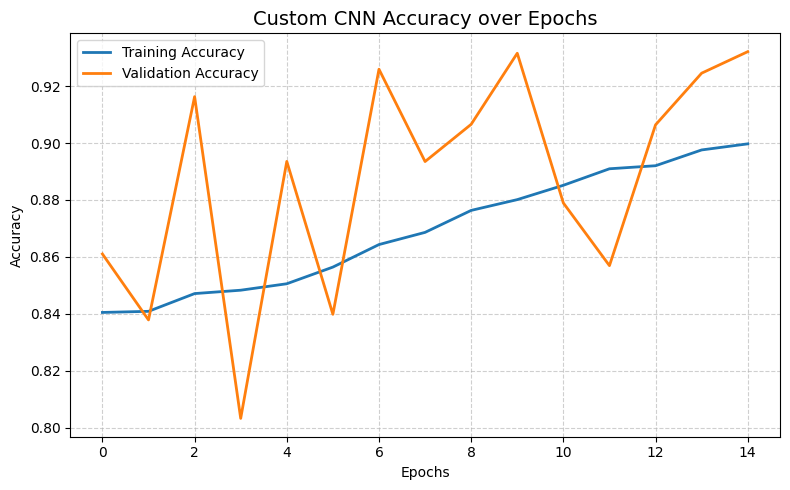

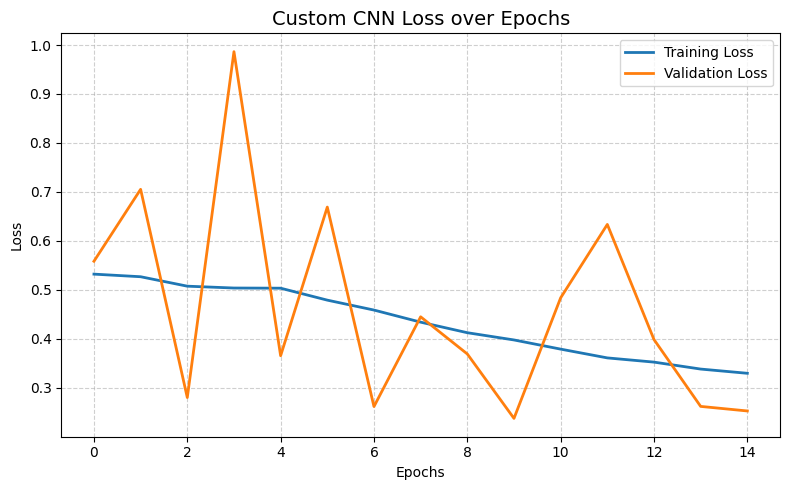

Custom CNN training performance visualized successfully!


In [ ]:
import matplotlib.pyplot as plt

if 'history_cnn' in locals():
    history_dict = history_cnn.history

    # Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('accuracy', []), label='Training Accuracy', linewidth=2)
    plt.plot(history_dict.get('val_accuracy', []), label='Validation Accuracy', linewidth=2)
    plt.title('Custom CNN Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('loss', []), label='Training Loss', linewidth=2)
    plt.plot(history_dict.get('val_loss', []), label='Validation Loss', linewidth=2)
    plt.title('Custom CNN Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("Custom CNN training performance visualized successfully!")
else:
    print("'history_cnn' not found. Train the CNN first.")


### Model Evaluation – Classification Report and Confusion Matrix

In this section, we evaluate the trained CNN model on the validation dataset using key classification metrics.

Steps performed:
- **Evaluation Generator:** A separate data generator is created for the validation subset with only rescaling and no shuffling to ensure predictions align correctly with true labels.  
- **Predictions:** The trained model generates predictions for all validation images.  
- **Performance Metrics:**
  - A **classification report** is printed showing precision, recall, and F1-score for each class.  
  - A **normalized confusion matrix** is plotted to visualize model performance and identify misclassified classes.  

This evaluation provides detailed insights into how well the CNN generalizes to unseen data and highlights any class imbalance issues.


Found 21707 images belonging to 38 classes.
Generating predictions on validation set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step
Predictions shape: (21707, 38)
Predicted indices: (21707,)
True indices: (21707,)

Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.938     0.718     0.813       252
                                 Apple___Black_rot      0.942     0.859     0.899       248
                          Apple___Cedar_apple_rust      0.989     0.791     0.879       110
                                   Apple___healthy      0.830     0.874     0.851       658
                               Blueberry___healthy      0.981     0.883     0.930       600
          Cherry_(including_sour)___Powdery_mildew      0.986     0.819     0.895       420
                 Cherry_(including_sour)___healthy      0.950     0.883     0.915       341
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.722     0.824     0.770       205
                   

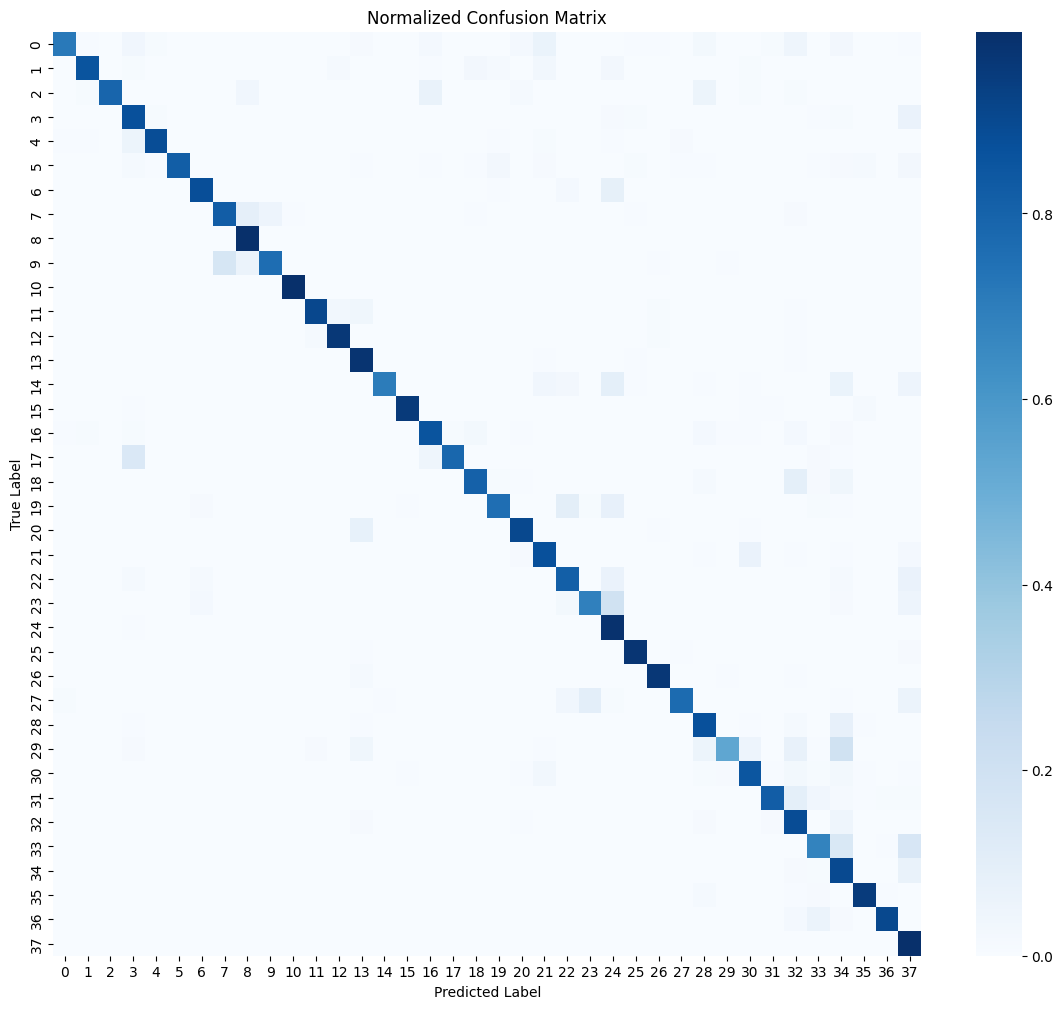

In [ ]:
# Model Evaluation: Classification Report + Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create non-shuffled validation generator
eval_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
eval_generator = eval_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generate predictions
print("Generating predictions on validation set...")
val_preds = model.predict(eval_generator, verbose=1)
y_pred = np.argmax(val_preds, axis=1)
y_true = eval_generator.classes
class_labels = list(eval_generator.class_indices.keys())

print(f"Predictions shape: {val_preds.shape}")
print(f"Predicted indices: {y_pred.shape}")
print(f"True indices: {y_true.shape}")

# Classification report
print("\nClassification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_labels, digits=3)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Detailed Evaluation – Precision, Recall, and F1-Score per Class

This section provides a deeper analysis of the model’s performance for each individual plant class.  
Instead of looking only at overall accuracy, we compute **precision**, **recall**, and **F1-score** to understand how well the model performs across all categories.

Steps performed:
- The function `precision_recall_fscore_support()` is used to calculate metrics for each class separately.  
- A summary table (DataFrame) lists each class along with its precision, recall, and F1-score values.  
- The top and bottom performing classes (based on F1-score) are displayed for quick insight.  
- A bar chart is generated to visually compare precision and recall values across classes.

This analysis helps identify which classes the model recognizes most accurately and which ones may need additional data or fine-tuning.


--- Top Performing Classes ---


,Class,Precision,Recall,F1-Score
10,Corn_(maize)___healthy,0.997835,0.993534,0.995680
15,Orange___Haunglongbing_(Citrus_greening),0.996207,0.954133,0.974716
25,Squash___Powdery_mildew,0.972789,0.974114,0.973451
26,Strawberry___Leaf_scorch,0.955457,0.968397,0.961883
35,Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.971851,0.950980,0.961303
12,Grape___Esca_(Black_Measles),0.960289,0.962025,0.961156
24,Soybean___healthy,0.929298,0.987721,0.957619
8,Corn_(maize)___Common_rust_,0.908046,0.995798,0.949900
11,Grape___Black_rot,0.957494,0.906780,0.931447
4,Blueberry___healthy,0.981481,0.883333,0.929825



--- Bottom Performing Classes ---


,Class,Precision,Recall,F1-Score
27,Strawberry___healthy,0.880503,0.769231,0.821114
37,Tomato___healthy,0.698675,0.995283,0.821012
0,Apple___Apple_scab,0.937824,0.718254,0.813483
32,Tomato___Septoria_leaf_spot,0.751196,0.887006,0.813472
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,0.722222,0.824390,0.769932
33,Tomato___Spider_mites Two-spotted_spider_mite,0.820976,0.677612,0.742437
23,Raspberry___healthy,0.796875,0.689189,0.739130
34,Tomato___Target_Spot,0.566629,0.901961,0.696011
29,Tomato___Early_blight,0.895397,0.535000,0.669797
22,Potato___healthy,0.337931,0.816667,0.478049


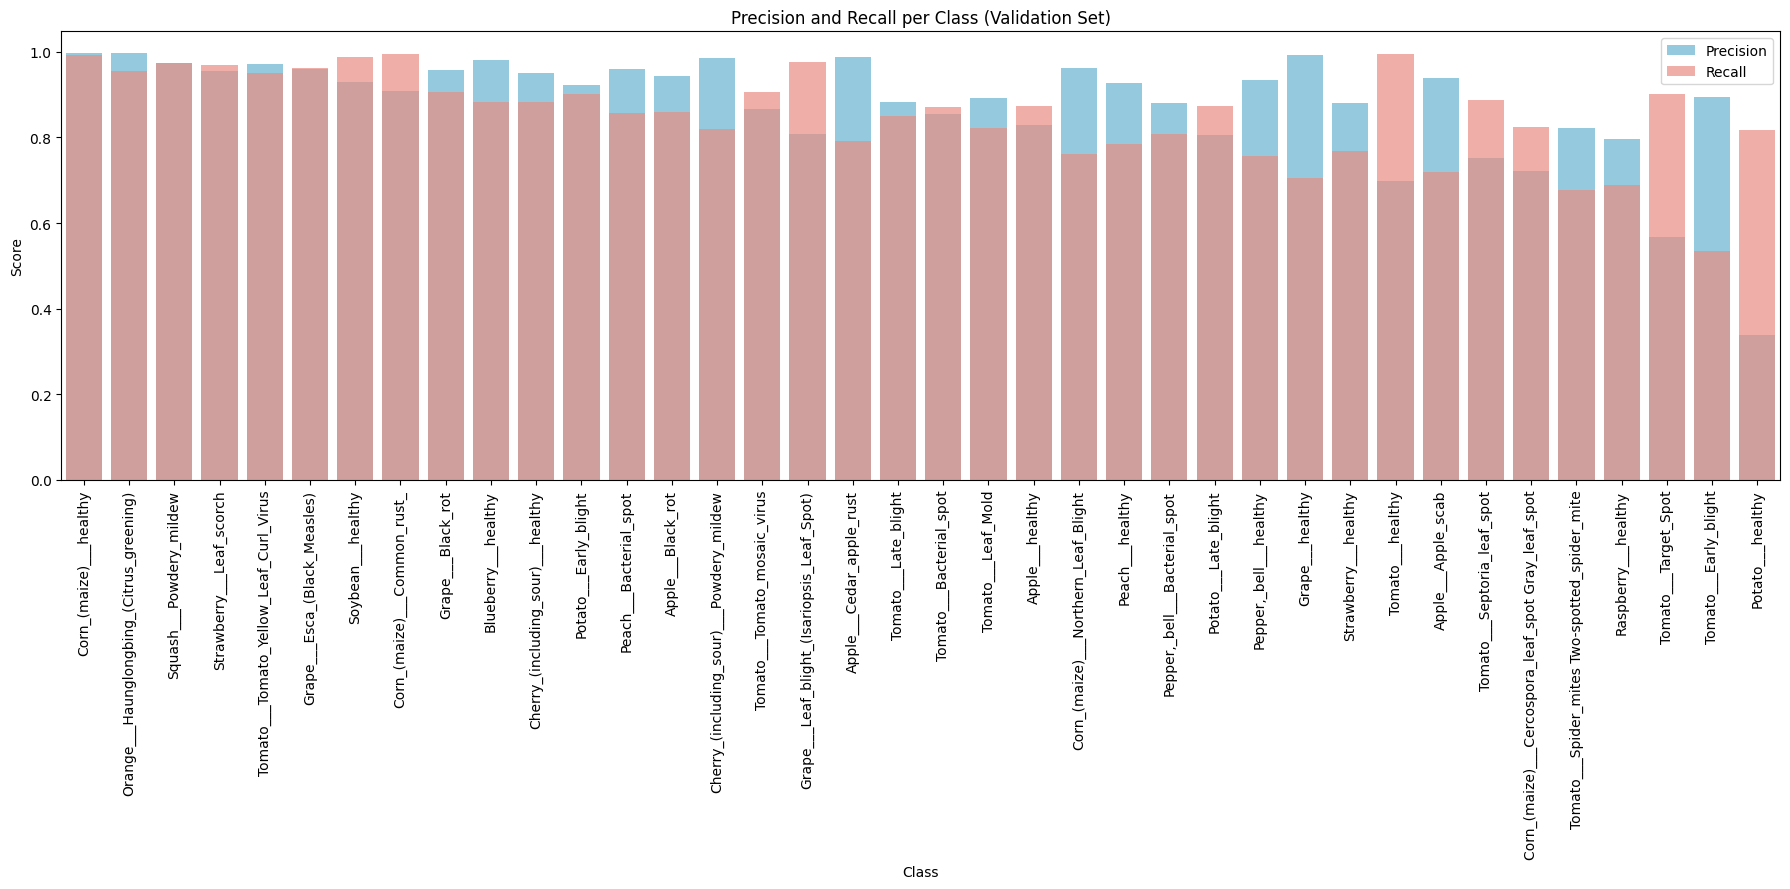

In [ ]:
# Detailed Evaluation – Precision, Recall, F1 per Class
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Check that predictions exist
if 'y_true' not in locals() or 'y_pred' not in locals() or 'class_labels' not in locals():
    raise NameError("Prediction variables not found. Run evaluation first.")

# Compute metrics
metrics = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=np.arange(len(class_labels))
)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': metrics[0],
    'Recall': metrics[1],
    'F1-Score': metrics[2]
}).sort_values(by='F1-Score', ascending=False)

# Display top and bottom classes
print("--- Top Performing Classes ---")
display(metrics_df.head(10))
print("\n--- Bottom Performing Classes ---")
display(metrics_df.tail(10))

# Visualization
plt.figure(figsize=(18, 9))
sns.barplot(x='Class', y='Precision', data=metrics_df, color='skyblue', label='Precision')
sns.barplot(x='Class', y='Recall', data=metrics_df, color='salmon', alpha=0.7, label='Recall')
plt.xticks(rotation=90)
plt.ylabel('Score')
plt.title('Precision and Recall per Class (Validation Set)')
plt.legend()
plt.tight_layout()
plt.show()

### Visualizing Random Model Predictions

In this step, we test the trained CNN model by making predictions on randomly selected plant leaf images from the dataset.  
This helps visually confirm how accurately the model distinguishes between **healthy** and **diseased** leaves.

Procedure:
- A few random images are selected from different classes.  
- Each image is resized to match the model’s input shape (64×64).  
- The model predicts the corresponding class label for each image.  
- The predicted results are displayed below each image for easy comparison.

This visualization provides an intuitive understanding of the model’s real-world performance and prediction reliability.


Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Peach___healthy/0a2ed402-5d23-4e8d-bc98-b264aea9c3fb___Rutg._HL 2471.JPG
Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Raspberry___healthy/6e41633c-1c44-44a6-9cc7-fd2d52a1f5c7___Mary_HL 9297_final_masked.jpg
Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Squash___Powdery_mildew/bc3b733c-1906-4538-b226-2427f2f8118d___UMD_Powd.M 0698.JPG
Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/1def114d-13d9-4e06-ad6e-556fa4137a10___FAM_L.Blight 4665.JPG
Testing on: /content/plantvillage/plantvillage dataset/combined_dataset/Apple___Cedar_apple_rust/3762c9a3-83db-44b7-88be-07c048ad293b___FREC_C.Rust 9945.JPG


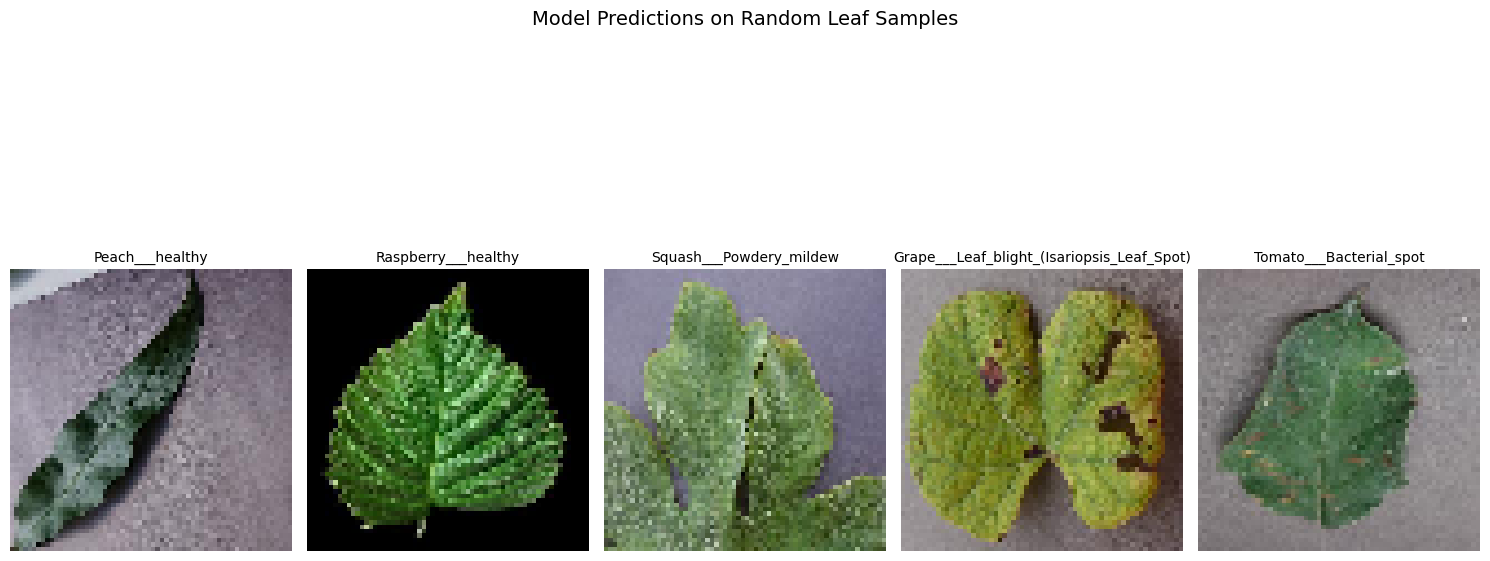

In [ ]:
# Visualize Random Predictions
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

num_samples = 5
DATA_DIR = merged_path

all_classes = os.listdir(DATA_DIR)
sampled_classes = random.sample(all_classes, num_samples)

plt.figure(figsize=(15, 8))

for i, cls in enumerate(sampled_classes):
    class_dir = os.path.join(DATA_DIR, cls)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    print(f"Testing on: {img_path}")

    img = image.load_img(img_path, target_size=(64, 64))
    img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    preds = model.predict(img_array, verbose=0)
    class_dict = {v: k for k, v in train_set.class_indices.items()}
    predicted_label = class_dict[np.argmax(preds)]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(predicted_label, fontsize=10)

plt.suptitle("Model Predictions on Random Leaf Samples", fontsize=14, y=0.98)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

### Visualizing Correct and Misclassified Images

In this step, we visually inspect examples of images that the model classified **correctly** and **incorrectly**.  
This helps in understanding the strengths and weaknesses of the model.

Procedure:
- The true and predicted labels from the validation set are compared.  
- Indices of correct and incorrect predictions are identified.  
- One correctly classified and one misclassified image are displayed side by side.  
- The predicted and true class labels are shown for each image.

By analyzing these results, we can gain insights into which types of leaves or disease categories the model finds most challenging to identify accurately.


✅ Correct predictions: 19369
❌ Incorrect predictions: 2338
Accuracy: 89.23%


/tmp/ipython-input-3367544946.py:46: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3367544946.py:46: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


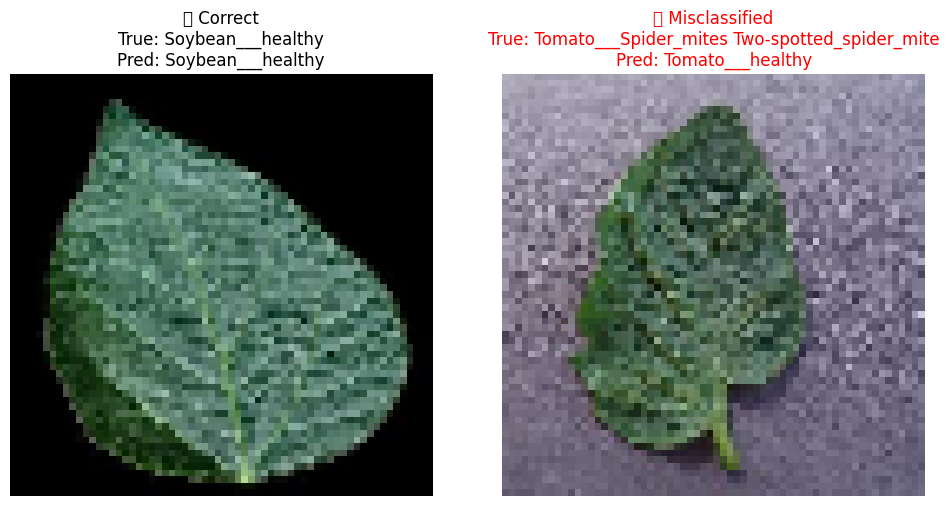

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Check required variables
if 'y_true' not in locals() or 'y_pred' not in locals() or 'eval_generator' not in locals() or 'class_labels' not in locals():
    raise NameError("Prediction variables not found. Run evaluation first.")

# Identify correct and incorrect predictions
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

print(f"✅ Correct predictions: {len(correct_indices)}")
print(f"❌ Incorrect predictions: {len(incorrect_indices)}")
print(f"Accuracy: {len(correct_indices) / len(y_true) * 100:.2f}%")

# Randomly select one correct and one incorrect example
correct_idx = random.choice(correct_indices) if len(correct_indices) > 0 else None
incorrect_idx = random.choice(incorrect_indices) if len(incorrect_indices) > 0 else None

plt.figure(figsize=(10, 5))

# Correctly classified image
if correct_idx is not None:
    img_path = eval_generator.filepaths[correct_idx]
    true_label = class_labels[y_true[correct_idx]]
    pred_label = class_labels[y_pred[correct_idx]]

    plt.subplot(1, 2, 1)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"✅ Correct\nTrue: {true_label}\nPred: {pred_label}")
    plt.axis("off")

# Misclassified image
if incorrect_idx is not None:
    img_path = eval_generator.filepaths[incorrect_idx]
    true_label = class_labels[y_true[incorrect_idx]]
    pred_label = class_labels[y_pred[incorrect_idx]]

    plt.subplot(1, 2, 2)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"❌ Misclassified\nTrue: {true_label}\nPred: {pred_label}", color='red')
    plt.axis("off")

plt.tight_layout()
plt.show()

### Predicting Plant Disease from a New Image

In this step, we use the trained CNN model to predict the disease category of a single plant leaf image.  
This simulates a real-world use case where the model receives a new image and provides an instant diagnosis.

Process:
- The image is loaded and resized to match the model’s input shape (64×64).  
- It is normalized and passed through the trained CNN model.  
- The model outputs class probabilities, from which the most likely class and confidence score are extracted.  
- The predicted disease name and confidence level are displayed, along with the input image.

This function demonstrates how the model can be integrated into an application for automated plant disease detection.


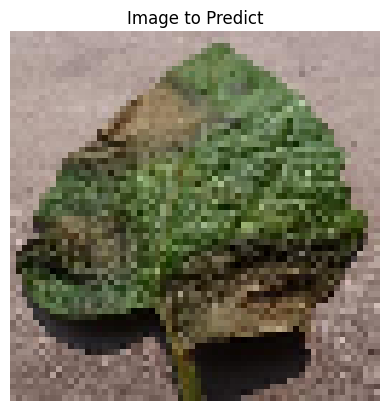

🌿 Predicted Disease: Potato___Late_blight (86.22% confidence)


('Potato___Late_blight', np.float32(86.21731))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

class_labels = list(train_set.class_indices.keys())

def predict_plant_disease(image_path, model, class_labels, target_size=(64, 64)):
    """Predict plant disease from an image using the trained CNN model."""
    try:
        img = image.load_img(image_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image to Predict")
        plt.show()

        img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
        predictions = model.predict(img_array, verbose=0)
        predicted_idx = np.argmax(predictions)
        confidence = np.max(predictions) * 100
        predicted_label = class_labels[predicted_idx]

        print(f"🌿 Predicted Disease: {predicted_label} ({confidence:.2f}% confidence)")
        return predicted_label, confidence

    except FileNotFoundError:
        print("❌ Image not found at the specified path.")
        return None, None
    except Exception as e:
        print(f"⚠️ Error: {e}")
        return None, None

# Example: change path to test different images
img_to_predict = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"

predict_plant_disease(img_to_predict, model, class_labels)

### Grad-CAM Visualization for CNN Interpretability

In this section, we apply **Grad-CAM (Gradient-weighted Class Activation Mapping)** to visualize which regions of the leaf image influenced the model’s prediction.  
This helps interpret how the CNN “sees” and understands disease features in plant leaves.

Steps involved:
1. **Load the trained CNN model** from the saved file.  
2. **Build a functional model** to access the last convolutional layer, which contains the spatial feature maps.  
3. **Construct a Grad-CAM model** that outputs both activations and gradients for visualization.  
4. **Load and preprocess a test image**, ensuring it matches the model’s input size.  
5. **Generate predictions** and identify the predicted disease class along with the confidence score.  
6. **Visualize the prediction**, showing the leaf image and preparing for the Grad-CAM heatmap overlay.

This technique provides transparency into how the CNN identifies key features in plant disease classification.


✅ Loaded model: Sequential
✅ Functional model created. Last Conv2D layer: conv2d_5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
✅ Grad-CAM model built successfully.
✅ Image loaded: (1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted: Potato___Late_blight (86.22% confidence)


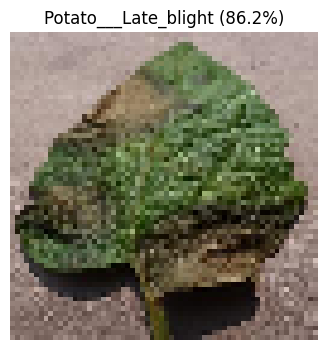

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt

# Load trained CNN model
base_model = load_model(cnn_model_path)
print("✅ Loaded model:", base_model.__class__.__name__)

# Build functional model to capture the last Conv2D layer
inp = Input(shape=(64, 64, 3))
x = inp
last_conv_tensor, last_conv_name = None, None

for layer in base_model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_tensor, last_conv_name = x, layer.name

if last_conv_tensor is None:
    raise ValueError("No Conv2D layer found in the model.")

model_xai = Model(inputs=inp, outputs=x)
print("✅ Functional model created. Last Conv2D layer:", last_conv_name)

# Warm-up model
_ = model_xai.predict(np.zeros((1, 64, 64, 3), dtype=np.float32))

# Build Grad-CAM helper model
grad_model = Model(inputs=inp, outputs=[last_conv_tensor, x])
print("✅ Grad-CAM model built successfully.")

# Load and preprocess test image
img_path = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"
orig_img = tf.keras.utils.load_img(img_path, target_size=(64, 64))
orig_img_array = tf.keras.utils.img_to_array(orig_img)
img_array = np.expand_dims(orig_img_array / 255.0, axis=0)
print("✅ Image loaded:", img_array.shape)

# Predict and display class
preds = model_xai.predict(img_array)
pred_class = int(np.argmax(preds[0]))
confidence = float(np.max(preds) * 100)

class_labels = list(train_set.class_indices.keys())
pred_label = class_labels[pred_class]

print(f"Predicted: {pred_label} ({confidence:.2f}% confidence)")

plt.figure(figsize=(4, 4))
plt.imshow(orig_img_array.astype("uint8"))
plt.title(f"{pred_label} ({confidence:.1f}%)")
plt.axis("off")
plt.show()

### Generating and Saving Grad-CAM Heatmap

In this step, we create a **Grad-CAM heatmap** to highlight the areas of the plant leaf image that most influenced the CNN model’s prediction.  
This visualization provides interpretability and helps confirm that the model focuses on meaningful disease features.

Steps performed:
1. **Compute Gradients:** Calculate the gradient of the predicted class score with respect to the feature maps of the last convolutional layer.  
2. **Generate the Heatmap:** Average the gradients across channels and apply a ReLU function to emphasize positive influences.  
3. **Overlay Visualization:** The heatmap is overlaid on the original image to visualize which leaf regions contributed most to the model’s decision.  
4. **Display Results:** Both the original image and the Grad-CAM overlay are displayed side by side for comparison.  
5. **Save Output:** The final visualization is saved to Google Drive for future reference.

This Grad-CAM analysis enhances model transparency and helps validate that the CNN’s focus aligns with disease-affected regions on the leaves.


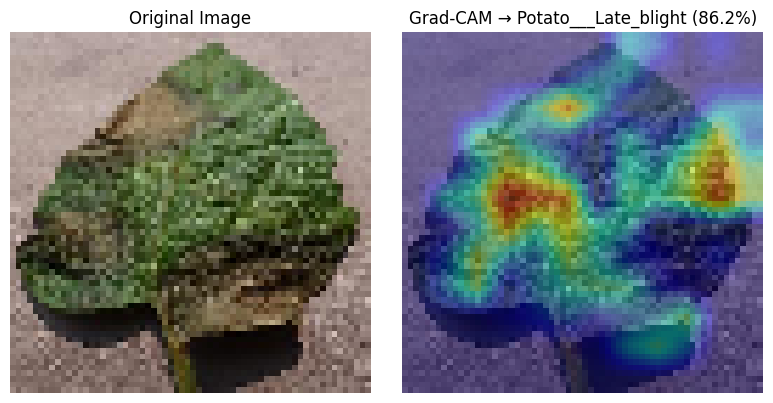

✅ Saved Grad-CAM visualization at: /content/drive/MyDrive/DeepLearningProject/GradCAM_Potato___Late_blight.jpg


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Ensure: grad_model, img_array, orig_img_array, pred_class, pred_label, confidence exist

# Compute Grad-CAM heatmap
img_tensor = tf.convert_to_tensor(img_array)
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_tensor, training=False)
    loss = predictions[:, pred_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
heatmap_np = heatmap.numpy()

# Overlay heatmap on original image
h, w = orig_img_array.shape[:2]
heatmap_resized = cv2.resize(heatmap_np, (w, h))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
orig_bgr = cv2.cvtColor(orig_img_array.astype("uint8"), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap_colored, 0.4, 0)

# Use unique variable names for this output
overlay_rgb_cnn = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
pred_label_cnn = pred_label
confidence_cnn = confidence

# Display visualization
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img_array.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb_cnn)
plt.title(f"Grad-CAM → {pred_label_cnn} ({confidence_cnn:.1f}%)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Save Grad-CAM output
save_dir = "/content/drive/MyDrive/DeepLearningProject"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, f"GradCAM_{pred_label_cnn.replace('/', '_')}.jpg")
cv2.imwrite(save_path, cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_RGB2BGR))
print("✅ Saved Grad-CAM visualization at:", save_path)

Data Drift Simulation and Analysis

In this step, we simulate new incoming data, compare it with the original training data, and check for data drift—a change in data distribution that can weaken model performance.

What this code does:

1. Create sample new data: Randomly selects 50 images from the merged dataset to mimic new unseen inputs.

2. Load new data: Uses ImageDataGenerator to preprocess and load the images.

3. Compare distributions: Computes and compares mean RGB pixel values between the original training batch and the new data batch.

4. Detect drift: If the difference exceeds a threshold, a drift warning is triggered.

5. Cleanup: Removes the temporary folder after analysis.

This helps ensure the model continues to receive data with a consistent distribution, maintaining reliable prediction accuracy.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil, random

# Create temporary folder for simulated new data
base_project_path = "/content/drive/MyDrive/DeepLearningProject"
new_data_path = os.path.join(base_project_path, "new_test_data")

# Clean existing folder if it exists
if os.path.exists(new_data_path):
    shutil.rmtree(new_data_path)
os.makedirs(new_data_path, exist_ok=True)

# Randomly copy a sample of 50 images from the merged dataset
all_images = [
    os.path.join(root, file)
    for root, _, files in os.walk(merged_path)
    for file in files
    if file.lower().endswith(('.png', '.jpg', '.jpeg'))
]

sample_images = random.sample(all_images, min(50, len(all_images)))
for img_path in sample_images:
    shutil.copy(img_path, new_data_path)

print(f"Created a sample of {len(sample_images)} new images at: {new_data_path}")

# Load the new data using ImageDataGenerator
new_data_gen = ImageDataGenerator(rescale=1./255)
new_data_flow = new_data_gen.flow_from_directory(
    base_project_path,
    classes=["new_test_data"],
    target_size=(64, 64),
    batch_size=16,
    class_mode=None,
    shuffle=False
)

# Compare pixel mean values between training data and new data
original_batch = next(train_set)[0]      # <-- already created during CNN training
original_means = np.mean(original_batch, axis=(0, 1, 2))
new_means = np.mean(new_data_flow[0], axis=(0, 1, 2))
diff = np.abs(original_means - new_means)

print("\n=== 📊 Data Drift Analysis ===")
print("Original Mean Pixel Values (RGB):", np.round(original_means, 4))
print("New Data Mean Pixel Values (RGB):", np.round(new_means, 4))
print("Absolute Difference:", np.round(diff, 4))

# Drift threshold check
threshold = 0.05
if np.any(diff > threshold):
    print("⚠️ WARNING: Potential data drift detected! Retraining or fine-tuning may be needed.")
else:
    print("✅ No significant data drift detected.")

# Cleanup temporary folder
shutil.rmtree(new_data_path)
print("Temporary new data folder removed successfully.")


Created a sample of 50 new images at: /content/drive/MyDrive/DeepLearningProject/new_test_data
Found 50 images belonging to 1 classes.

=== 📊 Data Drift Analysis ===
Original Mean Pixel Values (RGB): [0.2527 0.3076 0.2096]
New Data Mean Pixel Values (RGB): [0.3377 0.3755 0.2594]
Absolute Difference: [0.085  0.0679 0.0498]
⚠️ WARNING: Potential data drift detected! Retraining or fine-tuning may be needed.
Temporary new data folder removed successfully.


**SECTION 3 — CUSTOM MobileNetV2 MODEL**

### Transfer Learning with MobileNetV2 (Improved & Consistent)

In this step, we enhance model performance using **Transfer Learning** with a pre-trained **MobileNetV2** architecture.  
This approach leverages knowledge from large-scale datasets (like ImageNet) to improve plant disease detection accuracy with fewer training samples.

Workflow Overview:
1. **Load Pre-Trained Base Model:**  
   MobileNetV2 is imported with ImageNet weights and the top layers removed, acting as a feature extractor.  
   The convolutional layers are initially frozen to retain learned features.

2. **Add Custom Classification Layers:**  
   A Global Average Pooling layer, followed by Dense and Dropout layers, is added to adapt MobileNetV2 to our plant disease dataset.

3. **Learning Rate Scheduling:**  
   A custom learning rate scheduler is implemented to gradually reduce the learning rate, improving convergence stability.

4. **Compile and Train the Model:**  
   The model is trained on the augmented dataset using the Adam optimizer and categorical cross-entropy loss.  
   Early stopping and checkpoint callbacks ensure optimal model saving.

5. **Fine-Tuning (Optional):**  
   The top layers of MobileNetV2 are unfrozen for further fine-tuning at a lower learning rate to boost model accuracy.

This step demonstrates how transfer learning accelerates training and achieves higher accuracy in plant disease detection compared to training from scratch.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import tensorflow as tf
import os
import math

# Load pre-trained MobileNetV2 as feature extractor
base_model_mbn = MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model_mbn.trainable = False
print("MobileNetV2 base model loaded and frozen.")

# Add custom classification layers
model_mbn = Sequential([
    base_model_mbn,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_set.num_classes, activation='softmax')
])
print("Classification head added successfully.")

# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * math.exp(-0.1)

# Compile model
model_mbn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully.")

# Ensure save path exists
try:
    mobilenet_model_path
except NameError:
    mobilenet_model_path = "/content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras"
    os.makedirs(os.path.dirname(mobilenet_model_path), exist_ok=True)

# Define callbacks
checkpoint_mbn = ModelCheckpoint(
    filepath=mobilenet_model_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
early_stop_mbn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule_mbn = LearningRateScheduler(scheduler, verbose=1)

# Train MobileNetV2
print("\nTraining MobileNetV2 Model...")
history_mbn = model_mbn.fit(
    train_set,
    validation_data=val_set,
    epochs=20,
    callbacks=[checkpoint_mbn, early_stop_mbn, lr_schedule_mbn],
    verbose=1
)
print(f"\nMobileNetV2 training complete! Best model saved at:\n{mobilenet_model_path}")

# Optional Fine-Tuning Step (after stabilization)
base_model_mbn.trainable = True
for layer in base_model_mbn.layers[:-30]:  # Unfreeze top 30 layers only
    layer.trainable = False
model_mbn.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("Fine-tuning mode activated. Re-training can now continue.")

/tmp/ipython-input-1127237630.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mbn = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MobileNetV2 base model loaded and frozen.
Classification head added successfully.
Model compiled successfully.

Training MobileNetV2 Model...

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4748 - loss: 1.9144
Epoch 1: val_accuracy improved from -inf to 0.64532, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 272s 47ms/step - accuracy: 0.4748 - loss: 1.9144 - val_accuracy: 0.6453 - val_loss: 1.1512 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5777 - loss: 1.4462
Epoch 2: val_accuracy improved from 0.64532 to 0.65513, saving model to /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 225s 41ms/step - accuracy: 0.5777 - loss: 1.4462 - val_accuracy: 0.6551 - val_loss: 1.1415 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
5432/5432 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5902 - loss: 1.39

### **Saving MobileNetV2 Training History**

This step saves the MobileNetV2 model’s training history (accuracy, loss, validation metrics, etc.) into a JSON file.
Storing the history allows you to:

Reload training metrics later

Plot graphs without retraining

Keep a record of model performance

The history is saved to Google Drive for easy access and long-term storage.

In [ ]:
import json

history_save_path = "/content/drive/MyDrive/DeepLearningProject/history/history_mobilenet.json"
os.makedirs(os.path.dirname(history_save_path), exist_ok=True)

with open(history_save_path, 'w') as f:
    json.dump(history_mbn.history, f)

print("📁 MobileNet training history saved to:", history_save_path)


📁 MobileNet training history saved to: /content/drive/MyDrive/DeepLearningProject/history/history_mobilenet.json


###**Loading the Saved MobileNetV2 Model**

This step loads the best-trained MobileNetV2 model from the saved file path.
We then print a confirmation message and display the full model summary, allowing you to verify that the architecture and weights were loaded correctly.

In [ ]:
from tensorflow.keras.models import load_model

print(f"Loading saved MobileNetV2 model from: {mobilenet_model_path}")
model_mbn = load_model(mobilenet_model_path)
print("Model loaded successfully!")
model_mbn.summary()


Loading saved MobileNetV2 model from: /content/drive/MyDrive/DeepLearningProject/models/best_mobilenet_model.keras
Model loaded successfully!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,271,092 (12.48 MB)

 Trainable params: 337,702 (1.29 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 675,406 (2.58 MB)

### Visualizing MobileNetV2 Training Performance

After training the **MobileNetV2** model, it’s important to analyze how the model performed over epochs.  
This step visualizes both **accuracy** and **loss trends** for training and validation sets to help assess convergence and generalization.

Visualization includes:
1. **Accuracy Plot:**  
   - Shows how training and validation accuracy evolve over epochs.  
   - Helps detect overfitting (if training accuracy rises while validation accuracy stagnates or drops).

2. **Loss Plot:**  
   - Displays how the loss function decreases during training.  
   - A smooth, downward trend indicates stable optimization, while fluctuations may suggest the need for tuning.

3. **Evaluation Insights:**  
   - Comparing both plots helps identify if the model is underfitting, overfitting, or well-balanced.  
   - The use of **EarlyStopping** ensures that the best model weights (based on validation loss) are retained.

By visualizing these metrics, we can confirm the effectiveness of transfer learning and fine-tuning applied to the MobileNetV2 model.


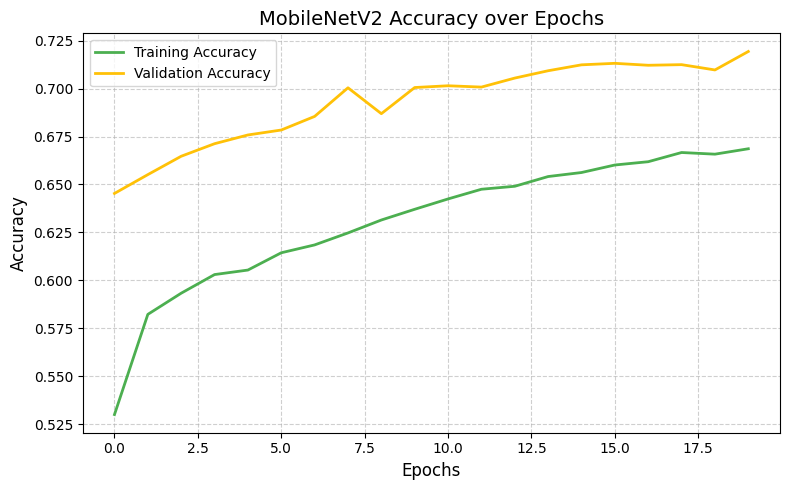

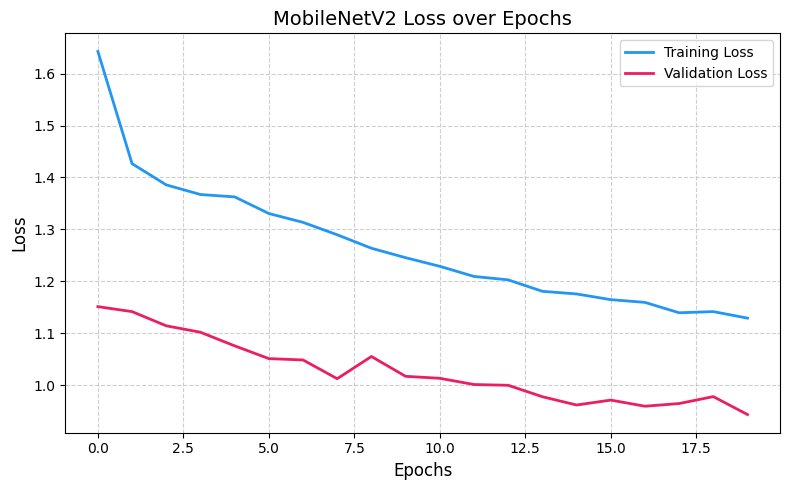

MobileNetV2 training performance visualized successfully!


In [ ]:
import matplotlib.pyplot as plt

if 'history_mbn' in locals():
    history_dict = history_mbn.history

    # Accuracy Plot
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('accuracy', []), label='Training Accuracy', color='#4CAF50', linewidth=2)
    plt.plot(history_dict.get('val_accuracy', []), label='Validation Accuracy', color='#FFC107', linewidth=2)
    plt.title('MobileNetV2 Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(history_dict.get('loss', []), label='Training Loss', color='#2196F3', linewidth=2)
    plt.plot(history_dict.get('val_loss', []), label='Validation Loss', color='#E91E63', linewidth=2)
    plt.title('MobileNetV2 Loss over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    print("MobileNetV2 training performance visualized successfully!")
else:
    print("'history_mbn' variable not found. Please train the MobileNetV2 model before plotting.")

### Full Evaluation for MobileNetV2

This section evaluates the **MobileNetV2** model on the validation set using the same non-shuffled generator to align predictions with true labels.

Steps performed:
- **Load best model:** The best checkpoint is loaded from `mobilenet_model_path`.
- **Evaluation generator:** A validation-only generator (no augmentation, `shuffle=False`) is created with the same image size used for training (64×64).
- **Predictions:** Model predictions are computed for the entire validation set.
- **Metrics:** A detailed **classification report** (precision, recall, F1-score) is printed for each class.
- **Confusion matrix:** A **normalized confusion matrix** is plotted to visualize per-class performance and common misclassifications.

This provides a comprehensive view of MobileNetV2’s generalization on unseen data.


Loading the best MobileNetV2 model for evaluation...
Found 21707 images belonging to 38 classes.
Generating predictions for MobileNetV2...


1357/1357 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step

Classification Report (MobileNetV2):

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.500     0.238     0.323       252
                                 Apple___Black_rot      0.652     0.613     0.632       248
                          Apple___Cedar_apple_rust      0.613     0.173     0.270       110
                                   Apple___healthy      0.625     0.646     0.635       658
                               Blueberry___healthy      0.669     0.837     0.744       600
          Cherry_(including_sour)___Powdery_mildew      0.932     0.555     0.696       420
                 Cherry_(including_sour)___healthy      0.714     0.812     0.760       341
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.698     0.541     0.610       205
                       Corn_(maize)___Common_rust_      0.769     0.929     0.841      

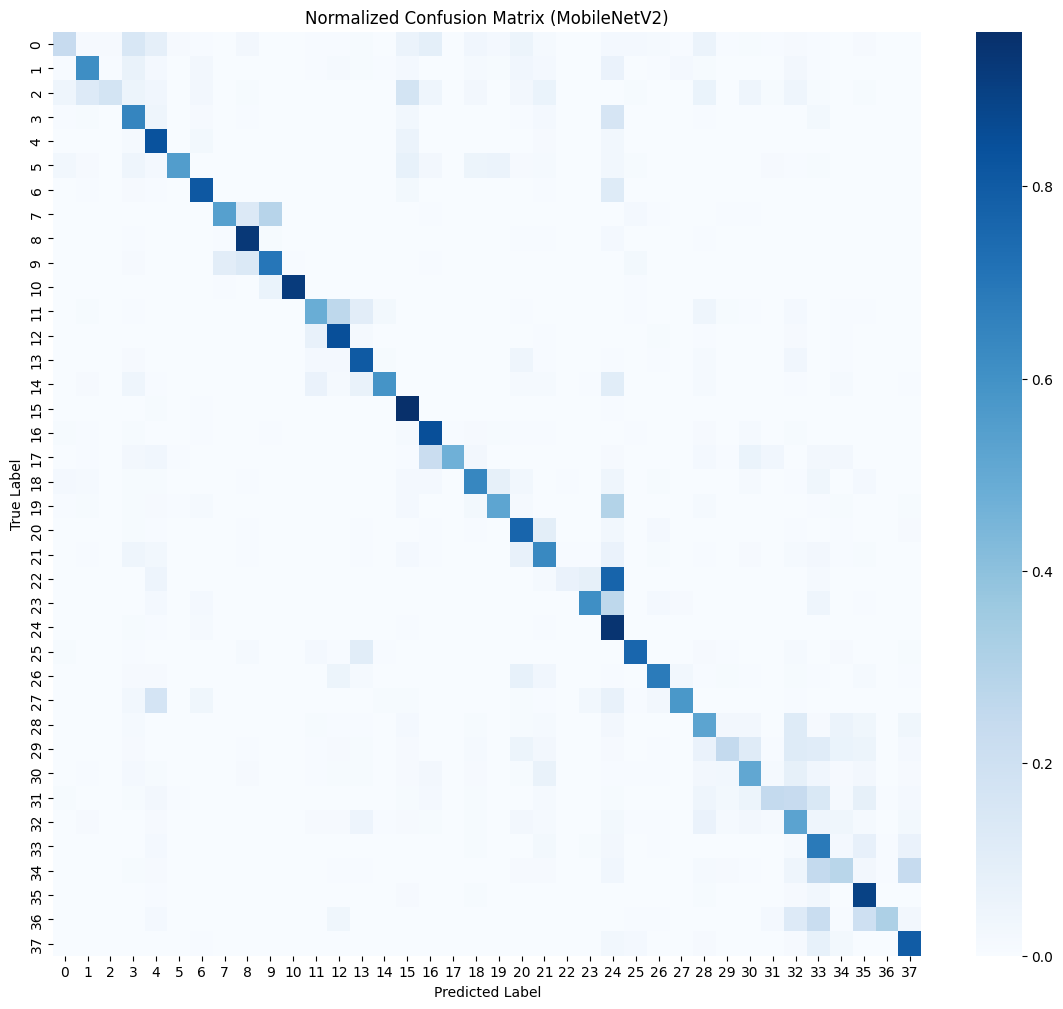

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print("Loading the best MobileNetV2 model for evaluation...")
model_mbn = load_model(mobilenet_model_path)

# Non-shuffled generator for evaluation
eval_generator_mbn = eval_datagen.flow_from_directory(
    merged_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Predictions and true labels
print("Generating predictions for MobileNetV2...")
val_preds_mbn = model_mbn.predict(eval_generator_mbn, verbose=1)
y_pred_mbn = np.argmax(val_preds_mbn, axis=1)
y_true_mbn = eval_generator_mbn.classes
class_labels_mbn = list(eval_generator_mbn.class_indices.keys())

# Classification report
print("\nClassification Report (MobileNetV2):\n")
report_mbn = classification_report(y_true_mbn, y_pred_mbn, target_names=class_labels_mbn, digits=3)
print(report_mbn)

# Normalized confusion matrix
cm_mbn = confusion_matrix(y_true_mbn, y_pred_mbn)
cm_normalized_mbn = cm_mbn.astype('float') / cm_mbn.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized_mbn, cmap='Blues')
plt.title('Normalized Confusion Matrix (MobileNetV2)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

###**Detailed Per-Class Evaluation (MobileNetV2):**

In this step, we generate class-wise precision, recall, and F1-score to understand how well MobileNetV2 performs on each disease category.

What this section does:

1. Computes detailed metrics using precision_recall_fscore_support for every class.

2. Creates a table showing each class with its precision, recall, and F1-score.

3. Highlights the top 10 best-performing and lowest-performing classes.

4. Visualizes class precision and recall using a comparative bar plot.

This analysis helps identify which plant diseases the model predicts reliably and which ones may require more data or fine-tuning.


=== Top Performing MobileNetV2 Classes ===


,Class,Precision,Recall,F1-Score
10,Corn_(maize)___healthy,0.995316,0.915948,0.953984
15,Orange___Haunglongbing_(Citrus_greening),0.883459,0.960490,0.920366
35,Tomato___Tomato_Yellow_Leaf_Curl_Virus,0.881488,0.895892,0.888632
16,Peach___Bacterial_spot,0.848419,0.847495,0.847956
8,Corn_(maize)___Common_rust_,0.768696,0.928571,0.841104
24,Soybean___healthy,0.732673,0.944990,0.825397
25,Squash___Powdery_mildew,0.895833,0.761580,0.823270
12,Grape___Esca_(Black_Measles),0.691852,0.844485,0.760586
6,Cherry_(including_sour)___healthy,0.713918,0.812317,0.759945
26,Strawberry___Leaf_scorch,0.823848,0.686230,0.748768



=== Lowest Performing MobileNetV2 Classes ===


,Class,Precision,Recall,F1-Score
21,Potato___Late_blight,0.493177,0.632500,0.554217
33,Tomato___Spider_mites Two-spotted_spider_mite,0.462387,0.688060,0.553089
32,Tomato___Septoria_leaf_spot,0.429066,0.525424,0.472381
36,Tomato___Tomato_mosaic_virus,0.783333,0.315436,0.449761
31,Tomato___Leaf_Mold,0.620000,0.244737,0.350943
34,Tomato___Target_Spot,0.444444,0.278075,0.342105
29,Tomato___Early_blight,0.480583,0.247500,0.326733
0,Apple___Apple_scab,0.500000,0.238095,0.322581
2,Apple___Cedar_apple_rust,0.612903,0.172727,0.269504
22,Potato___healthy,0.363636,0.066667,0.112676


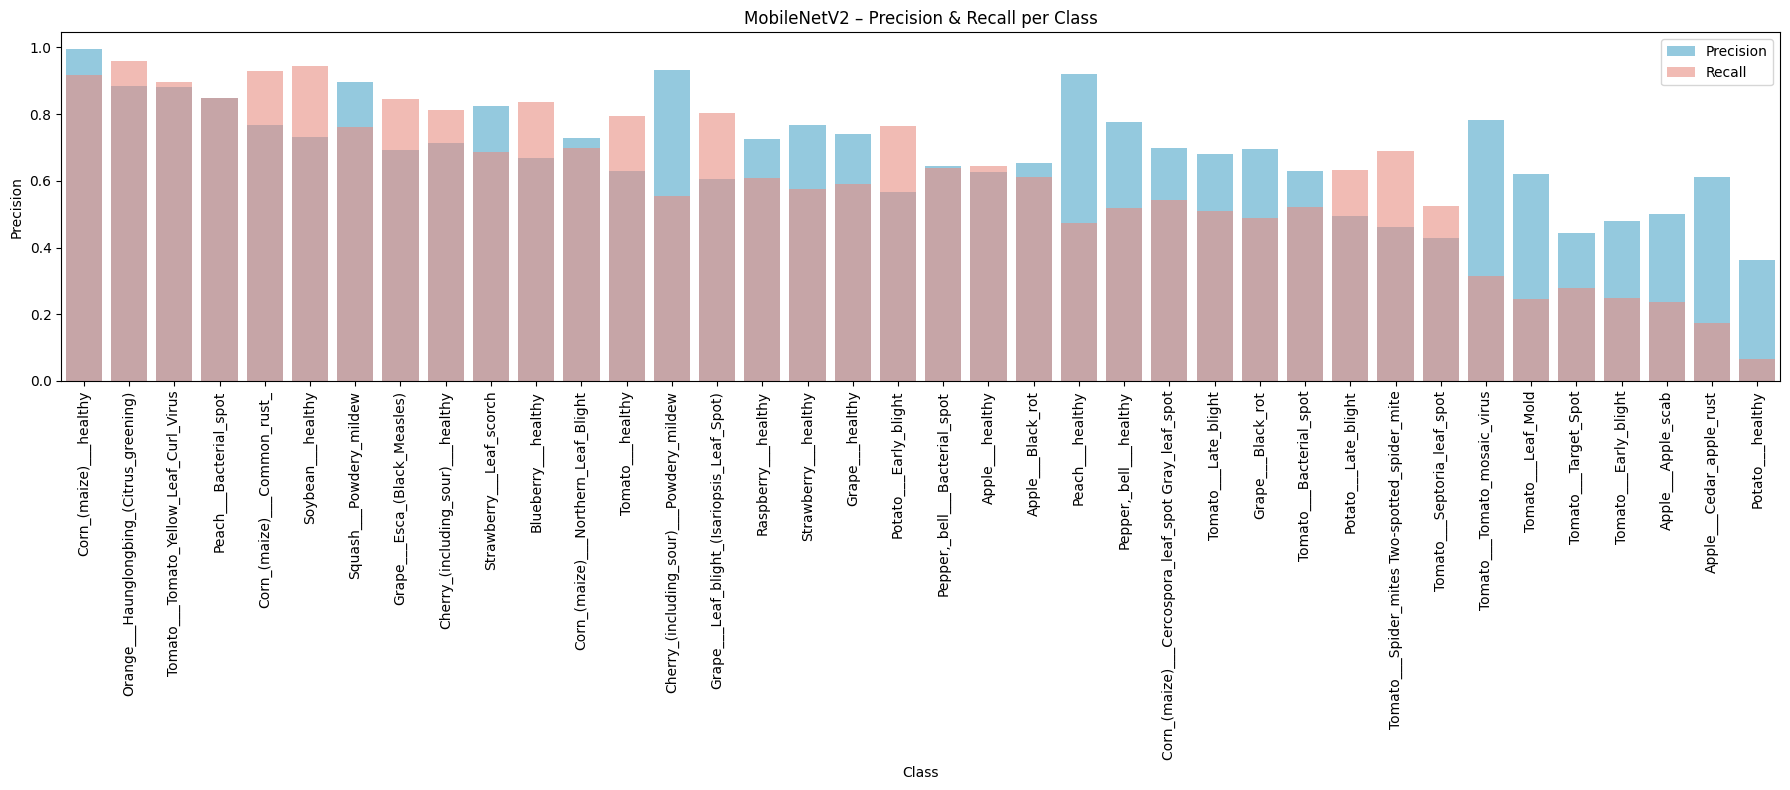

In [ ]:
# Detailed Per-Class Metrics (MobileNetV2)
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure predictions exist
if "y_true_mbn" not in locals() or "y_pred_mbn" not in locals():
    raise NameError("Run the MobileNetV2 evaluation cell first.")

metrics_mbn = precision_recall_fscore_support(
    y_true_mbn,
    y_pred_mbn,
    average=None,
    labels=np.arange(len(class_labels_mbn))
)

metrics_df_mbn = pd.DataFrame({
    "Class": class_labels_mbn,
    "Precision": metrics_mbn[0],
    "Recall": metrics_mbn[1],
    "F1-Score": metrics_mbn[2]
}).sort_values(by="F1-Score", ascending=False)

print("\n=== Top Performing MobileNetV2 Classes ===")
display(metrics_df_mbn.head(10))

print("\n=== Lowest Performing MobileNetV2 Classes ===")
display(metrics_df_mbn.tail(10))

plt.figure(figsize=(18, 8))
sns.barplot(x="Class", y="Precision", data=metrics_df_mbn, color="skyblue", label="Precision")
sns.barplot(x="Class", y="Recall", data=metrics_df_mbn, color="salmon", alpha=0.6, label="Recall")
plt.xticks(rotation=90)
plt.title("MobileNetV2 – Precision & Recall per Class")
plt.legend()
plt.tight_layout()
plt.show()


### Correct vs Incorrect Predictions (MobileNetV2)

This section visualizes how well the MobileNetV2 model performs by showing one correct prediction and one incorrect prediction side-by-side.

What this step does:

1. Identifies correct and incorrect predictions by comparing model outputs with true labels.

2. Counts overall accuracy based on prediction matches.

3. Randomly picks one correct and one incorrect example for visual inspection.

4. Displays both images with their true and predicted labels to understand typical success and failure cases.

5. Helps evaluate whether mistakes are due to visual similarity, low-quality images, or class imbalance.

Correct predictions: 15615
Incorrect predictions: 6092
Accuracy: 71.94%


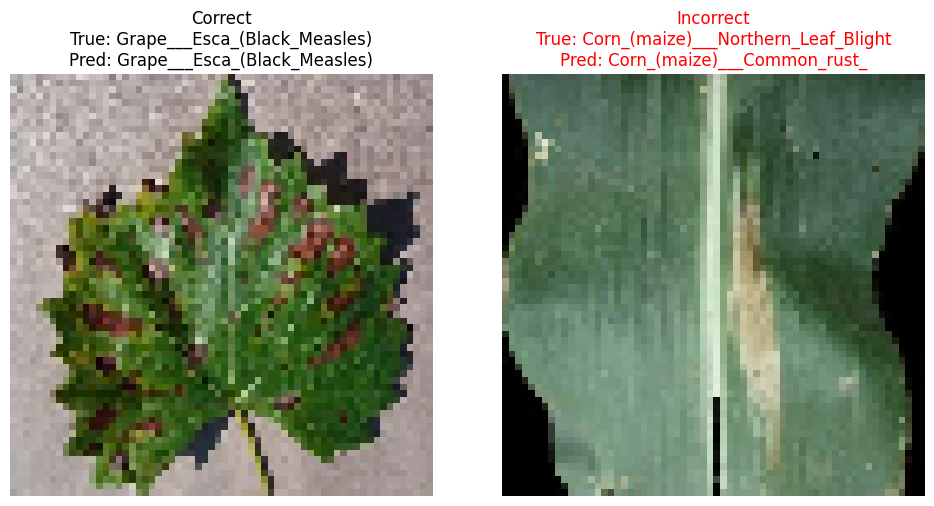

In [ ]:
# Correct vs Incorrect Predictions (MobileNetV2)
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

correct_idx_mbn = np.where(y_pred_mbn == y_true_mbn)[0]
incorrect_idx_mbn = np.where(y_pred_mbn != y_true_mbn)[0]

print(f"Correct predictions: {len(correct_idx_mbn)}")
print(f"Incorrect predictions: {len(incorrect_idx_mbn)}")
print(f"Accuracy: {(len(correct_idx_mbn) / len(y_true_mbn)) * 100:.2f}%")

pick_correct = random.choice(correct_idx_mbn) if len(correct_idx_mbn) else None
pick_incorrect = random.choice(incorrect_idx_mbn) if len(incorrect_idx_mbn) else None

plt.figure(figsize=(10, 5))

# SHOW CORRECT
if pick_correct is not None:
    img_path = eval_generator_mbn.filepaths[pick_correct]
    true_label = class_labels_mbn[y_true_mbn[pick_correct]]
    pred_label = class_labels_mbn[y_pred_mbn[pick_correct]]

    plt.subplot(1, 2, 1)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"Correct\nTrue: {true_label}\nPred: {pred_label}")
    plt.axis("off")

# SHOW INCORRECT
if pick_incorrect is not None:
    img_path = eval_generator_mbn.filepaths[pick_incorrect]
    true_label = class_labels_mbn[y_true_mbn[pick_incorrect]]
    pred_label = class_labels_mbn[y_pred_mbn[pick_incorrect]]

    plt.subplot(1, 2, 2)
    plt.imshow(image.load_img(img_path, target_size=(64, 64)))
    plt.title(f"Incorrect\nTrue: {true_label}\nPred: {pred_label}", color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Prediction Helper Function (MobileNetV2)

This function loads an image, prepares it for the MobileNetV2 model, and outputs the predicted plant disease along with confidence.

What happens here:

1. The input image is loaded and resized to 64×64, matching the model’s expected input.

2. It is normalized and passed through the trained MobileNetV2 model.

3. The model returns class probabilities, from which we extract:

    Predicted label

    Confidence score

4. The selected image is also displayed for reference.

This utility makes it easy to test any new leaf image and instantly get a disease prediction.

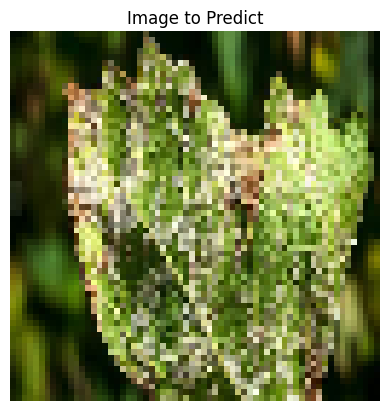


🌿 MobileNetV2 Prediction: Grape___Esca_(Black_Measles) (30.33%)


('Grape___Esca_(Black_Measles)', np.float32(30.330519))

In [ ]:
# Prediction Helper Function (MobileNetV2)
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_mobilenet(img_path):
    """Predict disease using your MobileNetV2 model."""
    try:
        img = image.load_img(img_path, target_size=(64, 64))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Image to Predict")
        plt.show()

        img_array = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)
        preds = model_mbn.predict(img_array, verbose=0)

        idx = np.argmax(preds)
        confidence = np.max(preds) * 100
        label = class_labels_mbn[idx]

        print(f"\n🌿 MobileNetV2 Prediction: {label} ({confidence:.2f}%)")
        return label, confidence

    except Exception as e:
        print("ERROR:", e)
        return None, None

# Example:
predict_mobilenet("/content/drive/MyDrive/DeepLearningProject/Sample_leaf.jpg")


### **Random Predictions Visualization (MobileNetV2)**

This section randomly selects a few plant leaf images from the merged dataset and shows how the MobileNetV2 model predicts their classes.

What this step does:

1. Randomly picks 5 classes from the dataset.

2. Selects one random image from each chosen class.

3. Loads and preprocesses the image.

4. Uses the MobileNetV2 model (model_mbn) to predict the disease class.

5. Displays each image along with the predicted label.

This provides a quick visual check of how well the model performs on general unseen images.

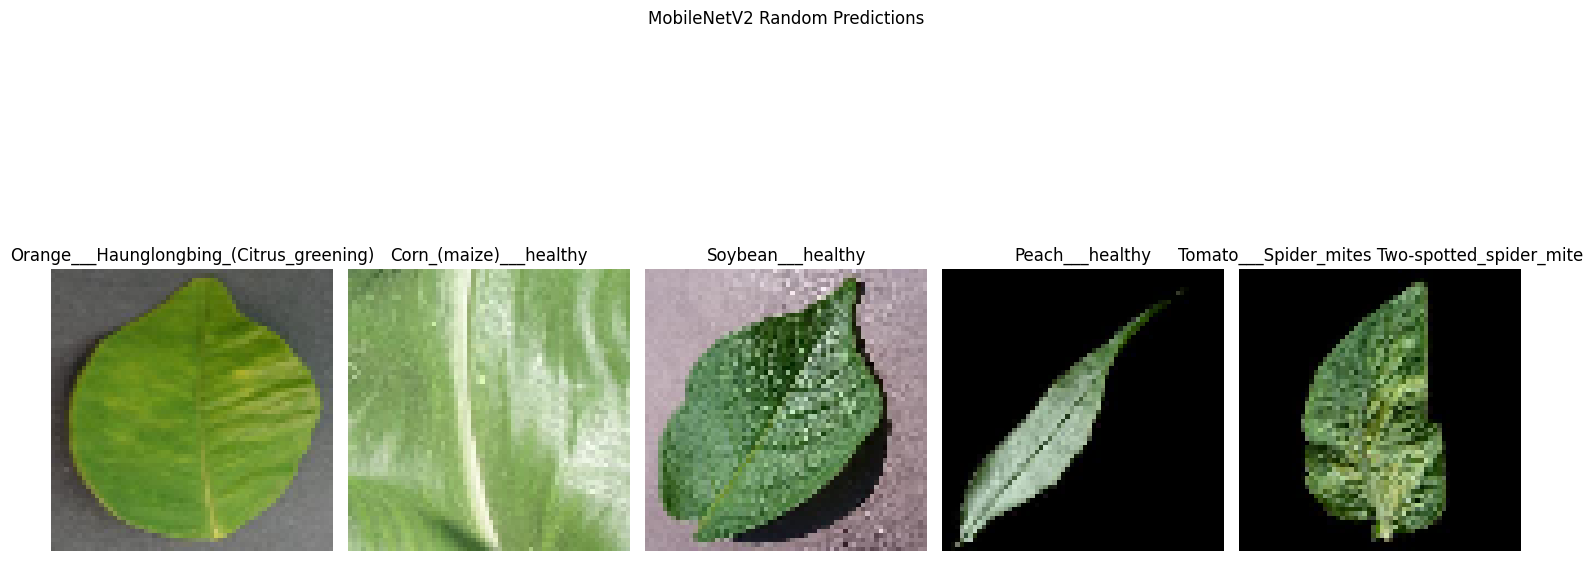

In [ ]:
# Random Predictions Visualization (MobileNetV2)
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

num_samples = 5
DATA_DIR = merged_path

all_classes = os.listdir(DATA_DIR)
sampled = random.sample(all_classes, num_samples)

plt.figure(figsize=(15, 8))

for i, cls in enumerate(sampled):
    class_dir = os.path.join(DATA_DIR, cls)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)

    img = image.load_img(img_path, target_size=(64, 64))
    arr = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

    preds = model_mbn.predict(arr, verbose=0)
    inv = {v: k for k, v in train_set.class_indices.items()}
    pred_label = inv[np.argmax(preds)]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(pred_label)
    plt.axis("off")

plt.suptitle("MobileNetV2 Random Predictions")
plt.tight_layout()
plt.show()


### Grad-CAM Visualization for MobileNetV2

This section applies Grad-CAM to the **MobileNetV2** transfer learning model to interpret its predictions by highlighting the image regions most influential for the chosen class.

Steps performed:
1. Load the trained MobileNetV2 model from disk.  
2. Extract the MobileNetV2 backbone and identify the last convolutional (or adjacent activation) layer to target for Grad-CAM.  
3. Build a functional model that outputs both the selected conv layer activations and the final predictions.  
4. Load and preprocess a test image to the model’s input size (64×64).  
5. Run inference to obtain the predicted class and confidence.  
6. Compute gradients with respect to the selected conv layer, generate the Grad-CAM heatmap, and normalize it.  
7. Overlay the heatmap on the original image, display both side by side, and save the visualization to Drive.

This interpretability step helps verify that the model focuses on disease-relevant areas in the leaf image.


Loaded MobileNetV2 model: Sequential
Targeting Grad-CAM layer: Conv_1
Grad-CAM model built successfully.
Image loaded and preprocessed: (1, 64, 64, 3)
Prediction (MobileNetV2): Tomato___Late_blight (22.16% confidence)


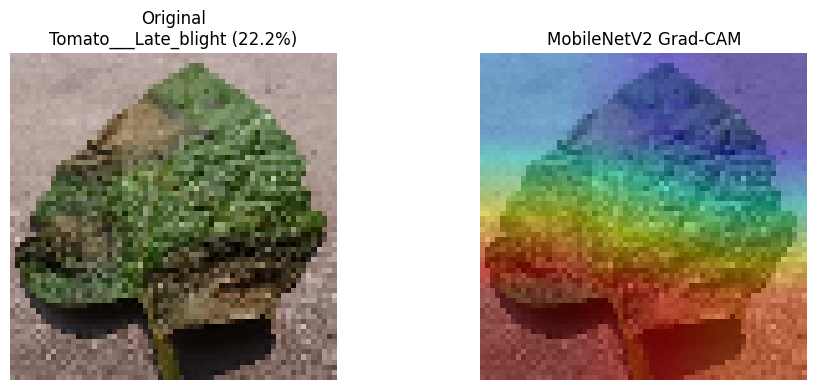

Grad-CAM image saved at: /content/drive/MyDrive/DeepLearningProject/models/GradCAM_MobileNetV2_Tomato___Late_blight.jpg


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the trained MobileNetV2 model
base_model_mbn = load_model(mobilenet_model_path)
print("Loaded MobileNetV2 model:", base_model_mbn.__class__.__name__)

# Extract MobileNetV2 backbone from Sequential model
mobilenet_layer = base_model_mbn.layers[0]
mobilenet_layer.trainable = False

# Find the last Conv2D layer for Grad-CAM
last_conv_layer_name_mbn = None
for layer in reversed(mobilenet_layer.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        try:
            next_layer_index = mobilenet_layer.layers.index(layer) + 1
            next_layer = mobilenet_layer.layers[next_layer_index]
            if isinstance(next_layer, (tf.keras.layers.ReLU, tf.keras.layers.Activation)):
                last_conv_layer_name_mbn = next_layer.name
            else:
                last_conv_layer_name_mbn = layer.name
        except IndexError:
            last_conv_layer_name_mbn = layer.name
        break

if last_conv_layer_name_mbn is None:
    raise ValueError("No Conv2D layer found in the MobileNetV2 base model.")

print(f"Targeting Grad-CAM layer: {last_conv_layer_name_mbn}")

# Build Grad-CAM-compatible model
inp_mbn = mobilenet_layer.input
last_conv_output_mbn = mobilenet_layer.get_layer(last_conv_layer_name_mbn).output
x = mobilenet_layer.output
for layer in base_model_mbn.layers[1:]:
    x = layer(x)
grad_model_mbn = Model(inputs=inp_mbn, outputs=[last_conv_output_mbn, x])
print("Grad-CAM model built successfully.")

# Load and preprocess a test image
img_path_mbn_test = "/content/plantvillage/plantvillage dataset/color/Tomato___Late_blight/00355ec2-f12c-4015-b8f9-94354f69ce22___RS_Late.B 5311.JPG"
orig_img = tf.keras.utils.load_img(img_path_mbn_test, target_size=(64, 64))
orig_img_array = tf.keras.utils.img_to_array(orig_img)
img_array_mbn_test = np.expand_dims(orig_img_array / 255.0, axis=0)
print("Image loaded and preprocessed:", img_array_mbn_test.shape)

# Predict class
preds_mbn = base_model_mbn.predict(img_array_mbn_test, verbose=0)
pred_class_mbn = np.argmax(preds_mbn[0])
confidence_mbn = np.max(preds_mbn[0]) * 100

class_indices_mbn = train_set.class_indices
inv_class_indices_mbn = {v: k for k, v in class_indices_mbn.items()}
pred_label_mbn = inv_class_indices_mbn.get(pred_class_mbn, "Unknown Class")
print(f"Prediction (MobileNetV2): {pred_label_mbn} ({confidence_mbn:.2f}% confidence)")

# Compute Grad-CAM heatmap
img_tensor_mbn = tf.convert_to_tensor(img_array_mbn_test)
with tf.GradientTape() as tape:
    conv_outputs_mbn, predictions_mbn = grad_model_mbn(img_tensor_mbn, training=False)
    loss_mbn = predictions_mbn[:, pred_class_mbn]

grads_mbn = tape.gradient(loss_mbn, conv_outputs_mbn)
pooled_grads_mbn = tf.reduce_mean(grads_mbn, axis=(0, 1, 2))
conv_outputs_mbn = conv_outputs_mbn[0]
heatmap_mbn = tf.reduce_sum(tf.multiply(pooled_grads_mbn, conv_outputs_mbn), axis=-1)
heatmap_mbn = np.maximum(heatmap_mbn, 0)
heatmap_mbn /= (np.max(heatmap_mbn) + 1e-8)
heatmap_resized_mbn = cv2.resize(heatmap_mbn, (orig_img_array.shape[1], orig_img_array.shape[0]))
heatmap_colored_mbn = cv2.applyColorMap(np.uint8(255 * heatmap_resized_mbn), cv2.COLORMAP_JET)

# Overlay heatmap on original image
orig_bgr = cv2.cvtColor(orig_img_array.astype("uint8"), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(orig_bgr, 0.6, heatmap_colored_mbn, 0.4, 0)
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Display Grad-CAM result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img_array.astype("uint8"))
plt.title(f"Original\n{pred_label_mbn} ({confidence_mbn:.1f}%)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title("MobileNetV2 Grad-CAM")
plt.axis("off")
plt.tight_layout()
plt.show()

# Save Grad-CAM visualization
save_path_mbn_gradcam = os.path.join(model_save_dir, f"GradCAM_MobileNetV2_{pred_label_mbn.replace('/', '_').replace(' ', '')}.jpg")
cv2.imwrite(save_path_mbn_gradcam, cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
print("Grad-CAM image saved at:", save_path_mbn_gradcam)

### Data Drift Detection (Local Version)

This step introduces a **Data Drift Detection** mechanism to monitor whether new incoming plant images differ significantly from the original training data distribution.  
Detecting drift early helps maintain model reliability and ensures accurate predictions in production environments.

#### 🔍 Process Overview:
1. **Simulated New Data Creation:**  
   A random subset of images is sampled from the existing dataset to act as *simulated new data*.  
   This represents what new incoming data might look like in a real deployment scenario.

2. **Image Loading and Normalization:**  
   Both the original and new datasets are loaded using `ImageDataGenerator` and normalized for comparison.

3. **Pixel Distribution Comparison:**  
   The **mean pixel values (RGB)** of both datasets are calculated and compared to detect color or lighting variations.

4. **Threshold-Based Drift Check:**  
   A small difference (≤ 0.05) between RGB means indicates stability, while larger gaps trigger a **drift warning**.  
   This helps identify potential domain shifts due to lighting, background, or camera differences.

5. **Automatic Cleanup:**  
   The temporary folder created for new data is deleted to maintain workspace cleanliness.

#### 💡 Why This Matters:
Data drift monitoring is crucial in real-world applications because it allows proactive retraining or fine-tuning when new unseen patterns start appearing in field data.  
This ensures that the model continues to make accurate and reliable predictions over time.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil, random

# Create temporary folder for simulated new data
base_project_path = "/content/drive/MyDrive/DeepLearningProject"
new_data_path = os.path.join(base_project_path, "new_test_data")

# Clean existing folder if it exists
if os.path.exists(new_data_path):
    shutil.rmtree(new_data_path)
os.makedirs(new_data_path, exist_ok=True)

# Randomly copy a sample of 50 images from the merged dataset
all_images = [
    os.path.join(root, file)
    for root, _, files in os.walk(merged_path)
    for file in files
    if file.lower().endswith(('.png', '.jpg', '.jpeg'))
]

sample_images = random.sample(all_images, min(50, len(all_images)))
for img_path in sample_images:
    shutil.copy(img_path, new_data_path)

print(f"Created a sample of {len(sample_images)} new images at: {new_data_path}")

# Load the new data using ImageDataGenerator
new_data_gen = ImageDataGenerator(rescale=1./255)
new_data_flow = new_data_gen.flow_from_directory(
    base_project_path,
    classes=["new_test_data"],
    target_size=(64, 64),
    batch_size=16,
    class_mode=None,
    shuffle=False
)

# Compare pixel mean values between training data and new data
original_batch = next(train_set)[0]
original_means = np.mean(original_batch, axis=(0, 1, 2))
new_means = np.mean(new_data_flow[0], axis=(0, 1, 2))
diff = np.abs(original_means - new_means)

print("\nData Drift Analysis")
print("Original Mean Pixel Values (RGB):", np.round(original_means, 4))
print("New Data Mean Pixel Values (RGB):", np.round(new_means, 4))
print("Absolute Difference:", np.round(diff, 4))

# Drift threshold check
threshold = 0.05
if np.any(diff > threshold):
    print("WARNING: Potential data drift detected! Consider retraining or fine-tuning the model.")
else:
    print("No significant data drift detected.")

# Cleanup temporary folder
shutil.rmtree(new_data_path)
print("Temporary new data folder removed successfully.")

Created a sample of 50 new images at: /content/drive/MyDrive/DeepLearningProject/new_test_data
Found 50 images belonging to 1 classes.

Data Drift Analysis
Original Mean Pixel Values (RGB): [0.2948 0.3486 0.2521]
New Data Mean Pixel Values (RGB): [0.2806 0.3134 0.2292]
Absolute Difference: [0.0142 0.0352 0.023 ]
No significant data drift detected.
Temporary new data folder removed successfully.


####**SECTION 5 - Comparision Block**

### Grad-CAM Comparison (CNN vs MobileNetV2)

This section compares interpretability between the custom **CNN** and the **MobileNetV2** transfer-learning model using their Grad-CAM overlays.

What happens here:
- A sanity check ensures both Grad-CAM results (from the CNN and MobileNetV2 steps) are available.
- The two heatmaps are displayed **side by side** to visually compare which image regions each model relies on.
- An optional combined image is saved to disk for reporting and documentation.

Use this comparison to assess whether both models focus on disease-relevant regions and to spot differences in attention that may explain performance gaps.


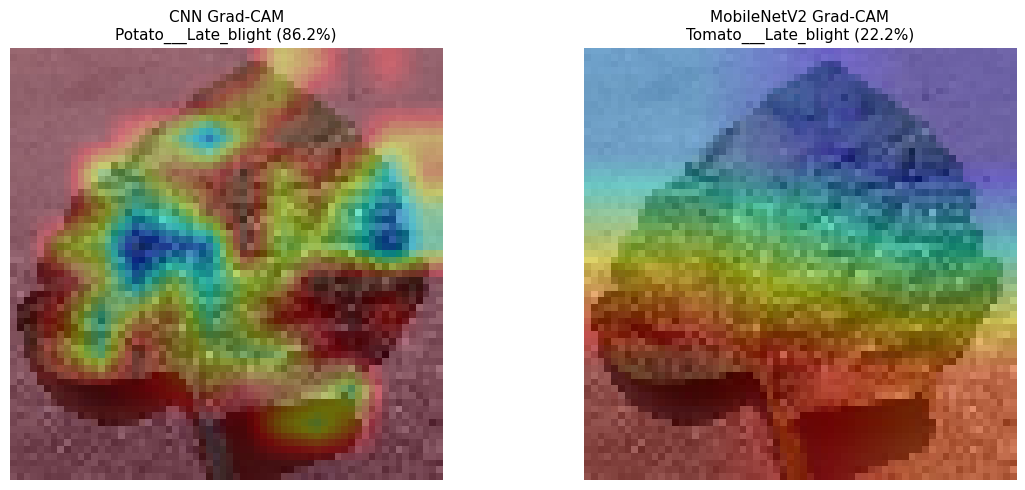

Grad-CAM comparison saved at: /content/drive/MyDrive/DeepLearningProject/models/GradCAM_Comparison_Tomato___Late_blight.jpg


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

# Ensure required Grad-CAM variables exist
required_vars = ['overlay_rgb_cnn', 'overlay_rgb', 'pred_label_cnn', 'pred_label_mbn']
for var in required_vars:
    if var not in locals():
        raise NameError(f"Missing variable: {var}. Please run both Grad-CAM cells first.")

# Side-by-side visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_BGR2RGB))
plt.title(f"CNN Grad-CAM\n{pred_label_cnn} ({confidence_cnn:.1f}%)", fontsize=11)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_rgb)
plt.title(f"MobileNetV2 Grad-CAM\n{pred_label_mbn} ({confidence_mbn:.1f}%)", fontsize=11)
plt.axis("off")

plt.tight_layout()
plt.show()

# Save comparison image
comparison_save_path = os.path.join(
    model_save_dir,
    f"GradCAM_Comparison_{pred_label_mbn.replace('/', '_').replace(' ', '')}.jpg"
)

# Stack the two overlays horizontally for saving
combined_overlay = np.hstack([
    cv2.cvtColor(overlay_rgb_cnn, cv2.COLOR_BGR2RGB),
    overlay_rgb
])
cv2.imwrite(comparison_save_path, cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR))

print("Grad-CAM comparison saved at:", comparison_save_path)

**Overall Accuracy Comparison (CNN vs MobileNetV2)**

This code automatically detects both models and their predictions, calculates test accuracy for each, and displays a bar chart comparing the performance of CNN and MobileNetV2.

CNN accuracy : 0.8922928087713641
MobileNetV2 accuracy : 0.7193532040355646


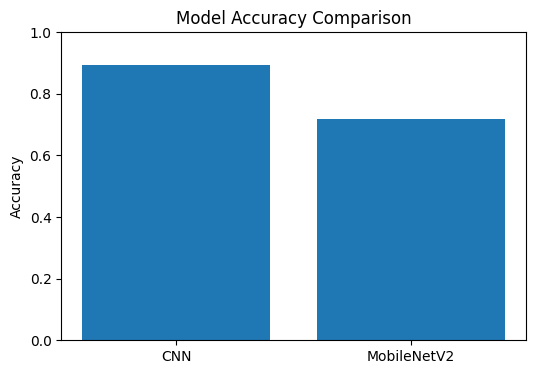

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ---- Auto-detect the CNN model ----
if 'cnn_model' in globals():
    model_cnn = cnn_model
elif 'model' in globals():
    model_cnn = model
else:
    raise NameError("CNN model not found. Expected variable: cnn_model or model")

# ---- Auto-detect the MobileNetV2 model ----
if 'mobilenet_model' in globals():
    model_mbn = mobilenet_model
elif 'model_mbn' in globals():
    model_mbn = model_mbn
else:
    raise NameError("MobileNet model not found. Expected variable: mobilenet_model or model_mbn")

# ---- Try to detect test labels (y_true) ----
if 'y_true' in globals():
    y_true_arr = np.array(y_true)
    if y_true_arr.ndim > 1:
        y_true_arr = np.argmax(y_true_arr, axis=1)
else:
    raise NameError("y_true is missing. Run the evaluation cell that generates y_true.")

# ---- Try to detect CNN predictions ----
if 'y_pred' in globals():
    y_pred_cnn = np.array(y_pred)
    if y_pred_cnn.ndim > 1:
        y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
else:
    raise NameError("y_pred not found. CNN predictions missing.")

# ---- Try to detect MobileNet predictions ----
if 'y_pred_mbn' in globals():
    y_pred_mbn_arr = np.array(y_pred_mbn)
    if y_pred_mbn_arr.ndim > 1:
        y_pred_mbn_arr = np.argmax(y_pred_mbn_arr, axis=1)
else:
    raise NameError("y_pred_mbn not found. MobileNet predictions missing.")

# ---- Compute accuracies ----
cnn_test_acc = accuracy_score(y_true_arr, y_pred_cnn)
mobilenet_test_acc = accuracy_score(y_true_arr, y_pred_mbn_arr)

print("CNN accuracy :", cnn_test_acc)
print("MobileNetV2 accuracy :", mobilenet_test_acc)

# ---- Bar chart ----
plt.figure(figsize=(6,4))
plt.bar(["CNN", "MobileNetV2"], [cnn_test_acc, mobilenet_test_acc])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


**F1-Score Comparison (CNN vs MobileNetV2)**

This code creates a table and heatmap that compares the F1-scores of both models for every class.
It helps visualize which model performs better on each disease category and where differences are the largest.

,CNN_F1,MobileNet_F1
Apple___Apple_scab,0.813483,0.322581
Apple___Black_rot,0.898734,0.632017
Apple___Cedar_apple_rust,0.878788,0.269504
Apple___healthy,0.851221,0.635277
Blueberry___healthy,0.929825,0.743704
Cherry_(including_sour)___Powdery_mildew,0.894668,0.695522
Cherry_(including_sour)___healthy,0.914894,0.759945
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0.769932,0.609890
Corn_(maize)___Common_rust_,0.949900,0.841104
Corn_(maize)___Northern_Leaf_Blight,0.849858,0.713359


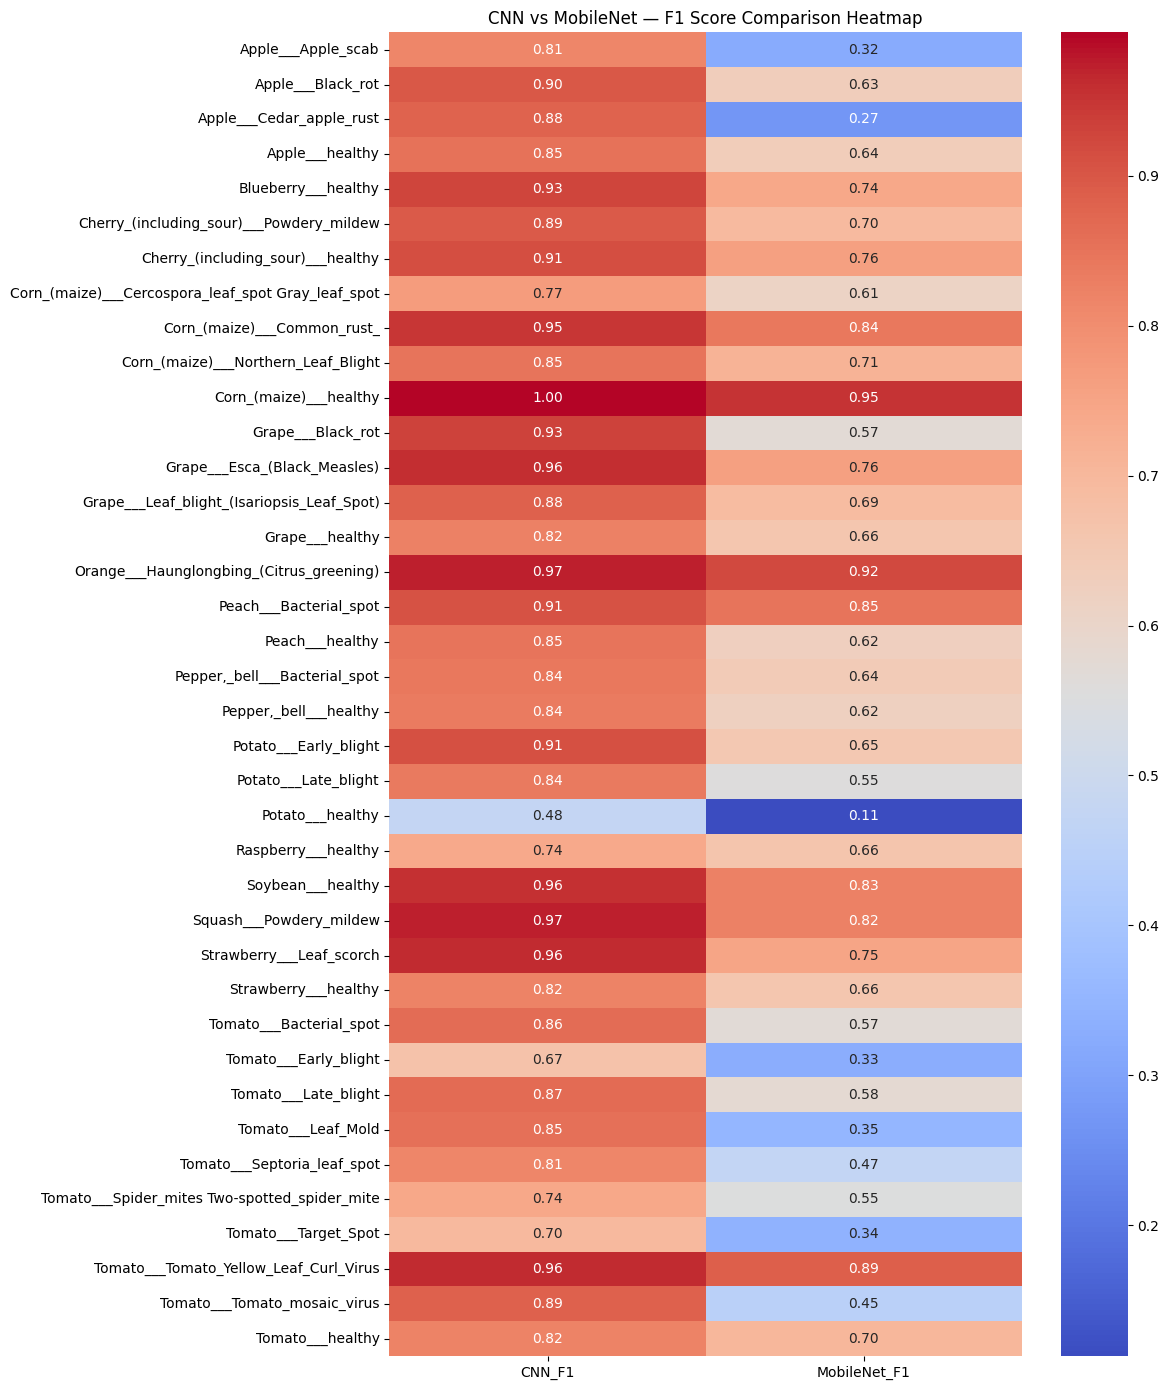

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Convert reports to DataFrames
cnn_df = pd.DataFrame(cnn_report).transpose().iloc[:-3]
mbn_df = pd.DataFrame(mbn_report).transpose().iloc[:-3]

# Create comparison matrix
comparison_matrix = pd.DataFrame({
    "CNN_F1": cnn_df["f1-score"],
    "MobileNet_F1": mbn_df["f1-score"],
})

# Display table
display(comparison_matrix)

# Heatmap
plt.figure(figsize=(12, 14))
sns.heatmap(comparison_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("CNN vs MobileNet — F1 Score Comparison Heatmap")
plt.tight_layout()
plt.show()


**Model Size Comparison**

This code compares how many trainable parameters each model has.
It prints the parameter counts and shows a bar chart so you can easily see which model is larger and more resource-heavy.

=== Model Size Comparison ===
Custom CNN Trainable Parameters: 688,998
MobileNetV2 Trainable Parameters: 2,595,686


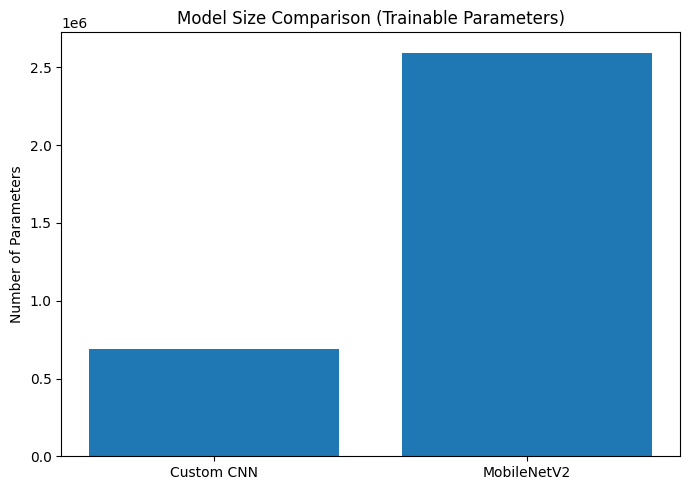

In [ ]:
import matplotlib.pyplot as plt

# ==== Model Size Comparison ====

# Count total trainable parameters
cnn_params = cnn_model.count_params()
mbn_params = mobilenet_model.count_params()

print("=== Model Size Comparison ===")
print(f"Custom CNN Trainable Parameters: {cnn_params:,}")
print(f"MobileNetV2 Trainable Parameters: {mbn_params:,}")

# ==== Optional Bar Chart ====
models = ["Custom CNN", "MobileNetV2"]
params = [cnn_params, mbn_params]

plt.figure(figsize=(7,5))
plt.bar(models, params)
plt.title("Model Size Comparison (Trainable Parameters)")
plt.ylabel("Number of Parameters")
plt.tight_layout()
plt.show()


**CNN vs MobileNetV2: Prediction Disagreement Analysis**

This section checks where the two models give different predictions on the same validation images.

What it does:

- Runs each validation image through both models.

- Compares their predicted labels.

- Stores every case where CNN and MobileNetV2 disagree.

Displays a few sample images showing:

- True label

- CNN prediction

- MobileNet prediction

Why it's useful:

- Helps see how differently the models behave.

- Shows which images or classes cause confusion.

- Useful for understanding model strengths and weaknesses.


Total Disagreement Cases: 6332


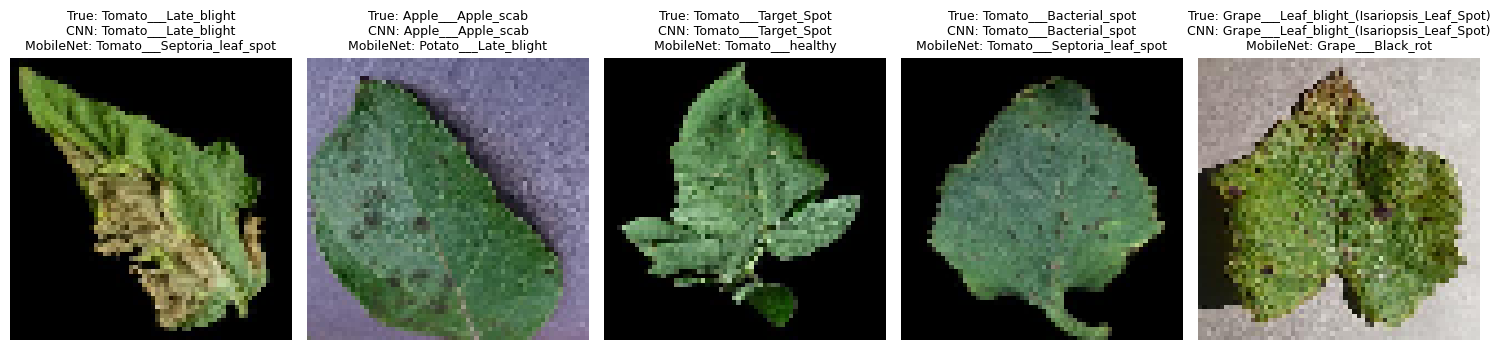

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Required variables
required_vars = ["cnn_model", "mobilenet_model", "val_set", "class_labels"]
for var in required_vars:
    if var not in globals():
        raise NameError(f"Missing variable: {var}")

# Extract all validation images & labels
X_val = []
Y_val = []

for batch_x, batch_y in val_set:
    X_val.extend(batch_x)
    Y_val.extend(batch_y)

    # Stop after one full epoch
    if len(X_val) >= val_set.samples:
        break

X_val = np.array(X_val)
y_true = np.argmax(np.array(Y_val), axis=1)

# Model predictions
cnn_preds = np.argmax(cnn_model.predict(X_val, verbose=0), axis=1)
mbn_preds = np.argmax(mobilenet_model.predict(X_val, verbose=0), axis=1)

# Find disagreements
disagreements = []

for idx in range(len(X_val)):
    if cnn_preds[idx] != mbn_preds[idx]:
        disagreements.append({
            "index": idx,
            "image": X_val[idx],
            "true": class_labels[y_true[idx]],
            "cnn": class_labels[cnn_preds[idx]],
            "mbn": class_labels[mbn_preds[idx]]
        })

print(f"\nTotal Disagreement Cases: {len(disagreements)}")

# Show sample disagreement images
if len(disagreements) > 0:
    to_show = min(5, len(disagreements))
    sample_cases = random.sample(disagreements, to_show)

    plt.figure(figsize=(15, 6))

    for i, case in enumerate(sample_cases):
        plt.subplot(1, to_show, i + 1)
        plt.imshow(case["image"])
        plt.axis("off")
        plt.title(
            f"True: {case['true']}\n"
            f"CNN: {case['cnn']}\n"
            f"MobileNet: {case['mbn']}",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()
else:
    print("Models do not disagree on any sample.")
